# Multi-Objective Fairness Analysis

This notebook implements multi-objective hyperparameter optimization for fairness-aware machine learning, exploring the trade-off between predictive accuracy and individual fairness.

## Approach 1: Models WITH Sensitive Features

In this approach, we train standard ML models (Random Forest, MLP) **with sensitive features included** in the training data, then evaluate fairness using counterfactual consistency.

### Objectives
| Objective | Description | Goal |
|-----------|-------------|------|
| **Accuracy** | Balanced accuracy on test set | Maximize |
| **Fairness** | Counterfactual consistency (prediction unchanged when flipping sensitive attribute) | Maximize |

### Visualizations
1. **Pareto Front** — Trade-off curves between accuracy and fairness
2. **Parallel Coordinates** — How hyperparameters affect both objectives
3. **MDS Projection** — 2D view of the hyperparameter search space
4. **Fairness Confusion Matrix** — Joint analysis of correctness and consistency

In [111]:
import importlib

# IMPORTANT: Reload datasets FIRST (before main) because main imports from datasets
datasets = importlib.import_module("utils.datasets")
importlib.reload(datasets)

plotting = importlib.import_module("utils.plotting")
importlib.reload(plotting)

# Now reload main (which depends on datasets)
main = importlib.import_module("main")
importlib.reload(main)



print("Modules reloaded successfully!")


Modules reloaded successfully!


In [112]:
# Add src to path
import sys
sys.path.insert(0, '../src')

# Import main module
from main import (
    main,
    run_optimization,
    get_dataset_config,
    get_configspace,
    list_available_datasets,
    get_pareto_front,
    print_pareto_summary,
    create_rf_model,  # NEW: to create models from configs
    create_mlp_model,  # NEW: to create models from configs
    # Fairness confusion matrix (NEW)
    compute_fairness_confusion_matrix,
    plot_fairness_confusion_matrix,
    print_fairness_confusion_summary,
)

# Import plotting functions from utils.plotting
from utils.plotting import (
    plot_pareto_comparison,
    plot_parallel_coordinates,
    plot_mds_projection,
    generate_all_visualizations,
)

from utils.datasets import load_dataset, create_flipped_data

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

print("Available datasets:", list_available_datasets())

Available datasets: ['adult', 'german_credit', 'compas']



## 1. Configuration & Setup

Define experiment parameters and load the dataset.

### 1.1 Experiment Configuration

In [114]:
import pickle
import os
from dataclasses import dataclass
from typing import Dict, List, Any

# =============================================================================
# Caching Configuration
# =============================================================================
LOAD_FROM_CACHE = False  # Set to True to load from cache instead of running optimization
CACHE_DIR = "../cache"   # Directory to store cached results

# Create cache directory if it doesn't exist
os.makedirs(CACHE_DIR, exist_ok=True)


@dataclass
class CachedConfig:
    """Simple wrapper to mimic ConfigSpace Configuration."""
    values: Dict[str, Any]
    
    def __getitem__(self, key):
        return self.values[key]
    
    def keys(self):
        return self.values.keys()
    
    def __iter__(self):
        return iter(self.values)
    
    def items(self):
        return self.values.items()


class CachedRunHistory:
    """Mock runhistory that provides the same interface as SMAC's runhistory."""
    
    def __init__(self, configs: List[Dict], costs: List[tuple]):
        self._configs = [CachedConfig(c) for c in configs]
        self._costs = {i: cost for i, cost in enumerate(costs)}
    
    def get_configs(self):
        return self._configs
    
    def average_cost(self, config):
        idx = self._configs.index(config)
        return self._costs[idx]


class CachedSMAC:
    """Mock SMAC facade that provides the same interface for visualization."""
    
    def __init__(self, configs: List[Dict], costs: List[tuple]):
        self.runhistory = CachedRunHistory(configs, costs)


def save_smac_results(results: Dict, dataset_name: str, sensitive_feature: str, approach: int = 1):
    """Save SMAC results to cache."""
    cache_data = {}
    
    for model_type, smac in results.items():
        configs = smac.runhistory.get_configs()
        configs_as_dicts = [dict(c) for c in configs]
        costs = [smac.runhistory.average_cost(c) for c in configs]
        
        cache_data[model_type] = {
            'configs': configs_as_dicts,
            'costs': costs,
        }
    
    cache_file = f"{CACHE_DIR}/smac_results_{dataset_name}_{sensitive_feature}_approach{approach}.pkl"
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    
    print(f"✅ Results cached to: {cache_file}")
    return cache_file


def load_smac_results(dataset_name: str, sensitive_feature: str, approach: int = 1) -> Dict:
    """Load SMAC results from cache."""
    cache_file = f"{CACHE_DIR}/smac_results_{dataset_name}_{sensitive_feature}_approach{approach}.pkl"
    
    if not os.path.exists(cache_file):
        raise FileNotFoundError(f"Cache file not found: {cache_file}\nRun optimization first with LOAD_FROM_CACHE=False")
    
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
    
    results = {}
    for model_type, data in cache_data.items():
        results[model_type] = CachedSMAC(data['configs'], data['costs'])
    
    print(f"✅ Results loaded from cache: {cache_file}")
    return results


print("Caching utilities loaded!")
print(f"LOAD_FROM_CACHE = {LOAD_FROM_CACHE}")

Caching utilities loaded!
LOAD_FROM_CACHE = False


In [84]:
# Experiment configuration
DATASET_NAME = "adult"          # Dataset to use
# SENSITIVE_FEATURE = "sex"       # Sensitive feature for counterfactual
SENSITIVE_FEATURE = 'race_all'

WALLTIME_LIMIT = 300           # Time limit per model (seconds) - increase for better results
N_TRIALS = 300                   # Max configurations per model - increase for better results

# Output directory
OUTPUT_DIR = "../plots"

print(f"Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Sensitive feature: {SENSITIVE_FEATURE}")
print(f"  Time limit per model: {WALLTIME_LIMIT}s")
print(f"  Max trials per model: {N_TRIALS}")


Configuration:
  Dataset: adult
  Sensitive feature: race_all
  Time limit per model: 300s
  Max trials per model: 300


### 1.2 Load Dataset

Load and preprocess the dataset with sensitive feature identification.

In [85]:
# Load dataset
data = load_dataset(DATASET_NAME, SENSITIVE_FEATURE)

# Extract for convenience (used in later analysis cells)
X_train = data['X_train']
y_train = data['y_train']

print(f"\nDataset Summary:")
print(f"  Shape: {X_train.shape}")

# Handle both binary and multiclass sensitive features
if data.get('is_multiclass', False):
    print(f"  Sensitive feature: MULTICLASS")
    print(f"    Columns: {data['sensitive_col_names']}")
    print(f"    Indices: {data['sensitive_col_indices']}")
    print(f"    Method: Exhaustive (flip to all other categories)")
else:
    print(f"  Sensitive feature: {data['sensitive_col_name']} (index {data['sensitive_col_idx']})")
    print(f"    Method: Binary flip (0 <-> 1)")

print(f"  Total features: {len(data['feature_names'])}")


Loading Adult Income from OpenML (ID: 179)...
APPROACH 1: Keeping sensitive features in training
  Sensitive feature for counterfactual: race_all
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Multiclass sensitive feature: race_all
  Columns (5): ['race_White', 'race_Black', 'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other']
  Indices: [41, 45, 42, 43, 44]

Final features (63): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 1):
  Samples: 45222, Features: 63
  Positive class ratio: 24.78%

Dataset Summary:
  Shape: (45222, 63)
  Sensitive feature: MULTICLASS
    Columns: ['race_White', 'race_Black', 'race_Asian-Pac-Islander',

## 2. Multi-Objective Optimization

Run SMAC (Sequential Model-based Algorithm Configuration) to find Pareto-optimal hyperparameter configurations that balance accuracy and fairness.

In [ ]:
%%time

# Run optimization OR load from cache
if LOAD_FROM_CACHE:
    print("Loading results from cache...")
    results = load_smac_results(DATASET_NAME, SENSITIVE_FEATURE, approach=1)
else:
    print("Running SMAC optimization...")
    results = {}
    
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()}...")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data,
            walltime_limit=WALLTIME_LIMIT,
            n_trials=N_TRIALS,
            output_dir="../smac_output"
        )
        results[model_type] = smac
    
    print("\n" + "="*60)
    print("Optimization complete!")
    print("="*60)
    
    # Save results to cache for future use
    save_smac_results(results, DATASET_NAME, SENSITIVE_FEATURE, approach=1)


Optimizing RF...

Running SMAC optimization for RF (Approach 1)
Using MULTICLASS counterfactual (exhaustive, 5 categories)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config 31471b is a new incumbent. Total number of incumbents: 4.
[INFO][smbo.py:327] Finished 50 trials.
[INFO][abstract_intensifier.py:596] Added config 8ade88 and rejected config 31471b as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:604] Config 2a4d3e is a

## 3. Results & Visualization

### 3.1 Pareto Front Analysis

The Pareto front shows the optimal trade-off between accuracy and counterfactual consistency. Points on the front represent configurations where improving one objective necessarily worsens the other.

- **X-axis**: Balanced Accuracy (higher = better predictions)
- **Y-axis**: Counterfactual Consistency (higher = more fair)
- **Pareto-optimal points**: Connected by dashed lines
- **Dominated points**: Lighter colored, suboptimal configurations

In [ ]:
# Generate optimization summary table
import pandas as pd

def get_optimization_stats(smac, model_name):
    """Extract statistics from SMAC optimization run."""
    runhistory = smac.runhistory
    
    # Number of configurations evaluated
    n_configs = len(runhistory.get_configs())
    
    # Get Pareto front size (final incumbents)
    pareto_configs, pareto_costs = get_pareto_front(smac)
    n_incumbents = len(pareto_configs)
    
    # Calculate total time and average time per config
    # Sum up all trial times from runhistory
    total_time = 0
    for key, value in runhistory.items():
        if value.time is not None:
            total_time += value.time
    
    avg_time = total_time / n_configs if n_configs > 0 else 0
    
    return {
        'Model': model_name.upper(),
        'Configs Evaluated': n_configs,
        'Pareto Front Size': n_incumbents,
        'Total Time (s)': f"{total_time:.1f}",
        'Avg Time/Config (s)': f"{avg_time:.2f}",
    }

# Build summary table
summary_data = []
for model_type, smac in results.items():
    stats = get_optimization_stats(smac, model_type)
    summary_data.append(stats)

summary_df = pd.DataFrame(summary_data)

print("=" * 70)
print("OPTIMIZATION SUMMARY")
print("=" * 70)
display(summary_df)

# Additional insights
print("\n" + "=" * 70)
print("INSIGHTS")
print("=" * 70)
for model_type, smac in results.items():
    n_configs = len(smac.runhistory.get_configs())
    pareto_configs, _ = get_pareto_front(smac)
    pareto_pct = len(pareto_configs) / n_configs * 100 if n_configs > 0 else 0
    print(f"{model_type.upper()}: {len(pareto_configs)}/{n_configs} configs are Pareto-optimal ({pareto_pct:.1f}%)")


OPTIMIZATION SUMMARY


Model  Configs Evaluated  Pareto Front Size Total Time (s)  \
0    RF                 54                 10          297.3   
1   MLP                 20                  8          300.3   

  Avg Time/Config (s)  
0                5.51  
1               15.02


INSIGHTS
RF: 10/54 configs are Pareto-optimal (18.5%)
MLP: 8/20 configs are Pareto-optimal (40.0%)


In [102]:
print_pareto_summary(results)


PARETO FRONT SUMMARY

RF Pareto Front (10 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7701, Consistency=0.9866
  Config 2: Accuracy=0.7658, Consistency=0.9926
  Config 3: Accuracy=0.7587, Consistency=0.9974
  Config 4: Accuracy=0.7583, Consistency=0.9975
  Config 5: Accuracy=0.7578, Consistency=0.9984
  Config 6: Accuracy=0.7578, Consistency=0.9984
  Config 7: Accuracy=0.7577, Consistency=0.9987
  Config 8: Accuracy=0.7565, Consistency=0.9997
  Config 9: Accuracy=0.7533, Consistency=0.9999
  Config 10: Accuracy=0.7434, Consistency=1.0000

  Best Accuracy: 0.7701 (Consistency: 0.9866)
  Best Consistency: 1.0000 (Accuracy: 0.7434)

MLP Pareto Front (8 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7831, Consistency=0.9624
  Config 2: Accuracy=0.7798, Consistency=0.9655
  Config 3: Accuracy=0.7791, Consistency=0.9660
  Config 4: Accuracy=0.7783, Consistency=0.9677
  Config 5: Accuracy=0.7759, Consi

[notebook] Pareto plot saved to: ../plots/notebook/pareto_adult_race_all.png
[latex] Pareto plot saved to: ../plots/latex/pareto_adult_race_all.png


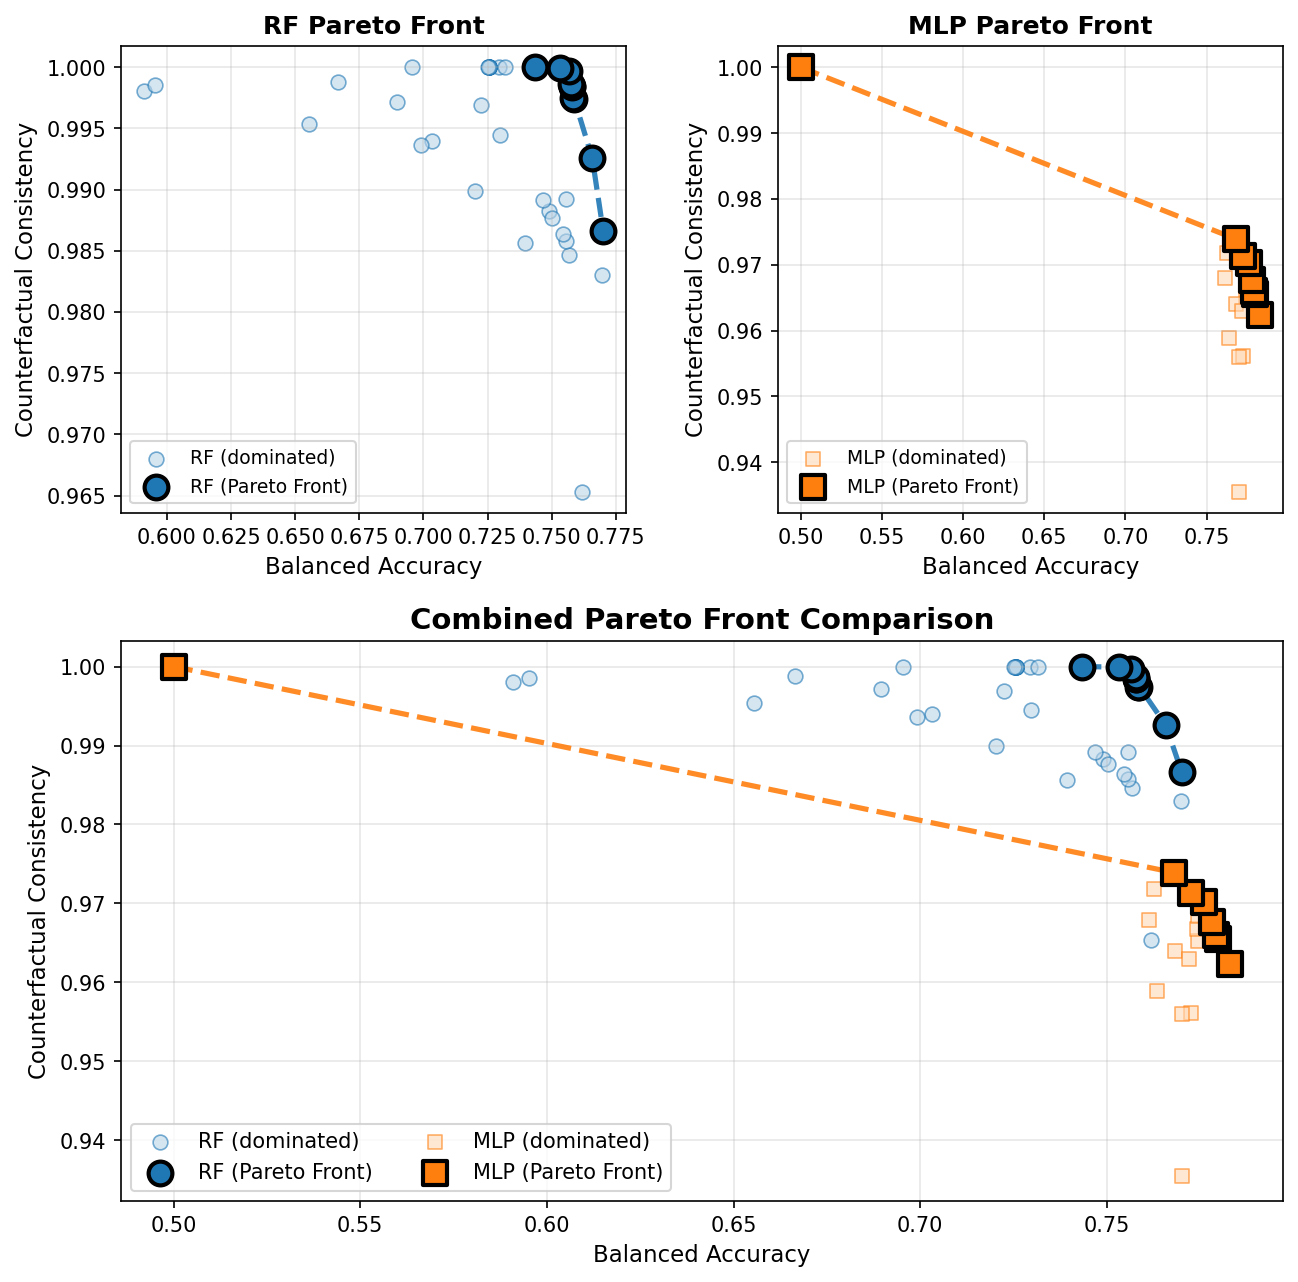

In [103]:
# Generate Pareto comparison plot (both notebook and latex versions)
pareto_filename = f"pareto_{DATASET_NAME}_{SENSITIVE_FEATURE}.png"
pareto_paths = plot_pareto_comparison(
    results, 
    output_dir=OUTPUT_DIR,
    filename=pareto_filename,
    formats=["notebook", "latex"]
)

# Display the notebook version
display(Image(filename=pareto_paths["notebook"]))

### 3.2 Parallel Coordinate Plots

Parallel coordinate plots visualize how hyperparameter configurations map to objective values.

| Element | Meaning |
|---------|---------|
| **Vertical axes** | Hyperparameters and objectives |
| **Lines** | Individual configurations |
| **Bold lines** | Pareto-optimal configurations |
| **Faint lines** | Dominated configurations |
| **Color** | Performance (green = better, red = worse) |

**Key insights:**
- Identify which hyperparameter ranges lead to better trade-offs
- Spot correlations between hyperparameters and objectives
- Assess diversity of the explored configuration space

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_race_all_rf.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_race_all_rf.png

Random Forest - Parallel Coordinate Plot:


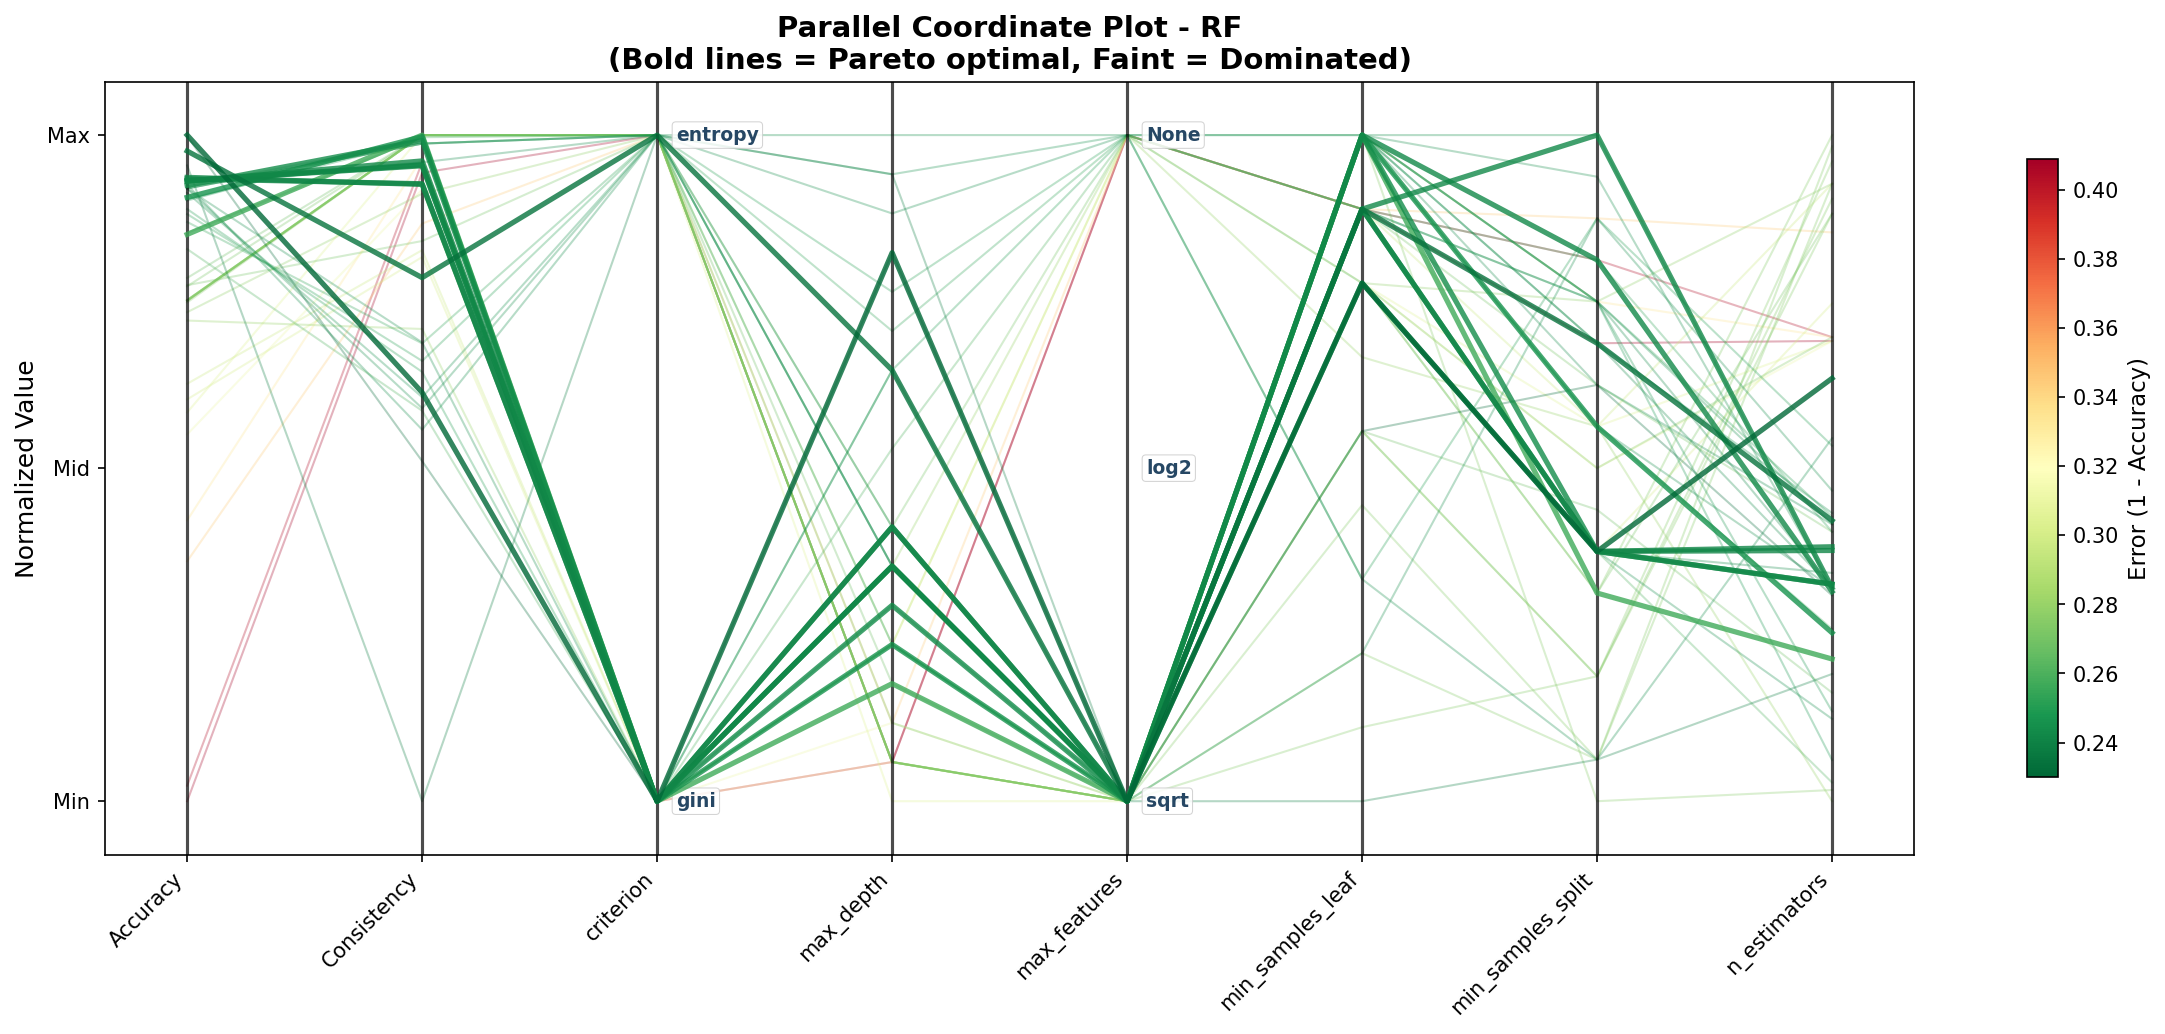

In [104]:
# Random Forest parallel coordinates (both notebook and latex versions)
rf_parallel_filename = f"parallel_coords_{DATASET_NAME}_{SENSITIVE_FEATURE}_rf.png"
rf_parallel_paths = plot_parallel_coordinates(
    results['rf'], 
    'rf',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=rf_parallel_filename,
    color_by='error',
    formats=["notebook", "latex"]
)

print("\nRandom Forest - Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_paths["notebook"]))

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_race_all_mlp.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_race_all_mlp.png

MLP - Parallel Coordinate Plot:


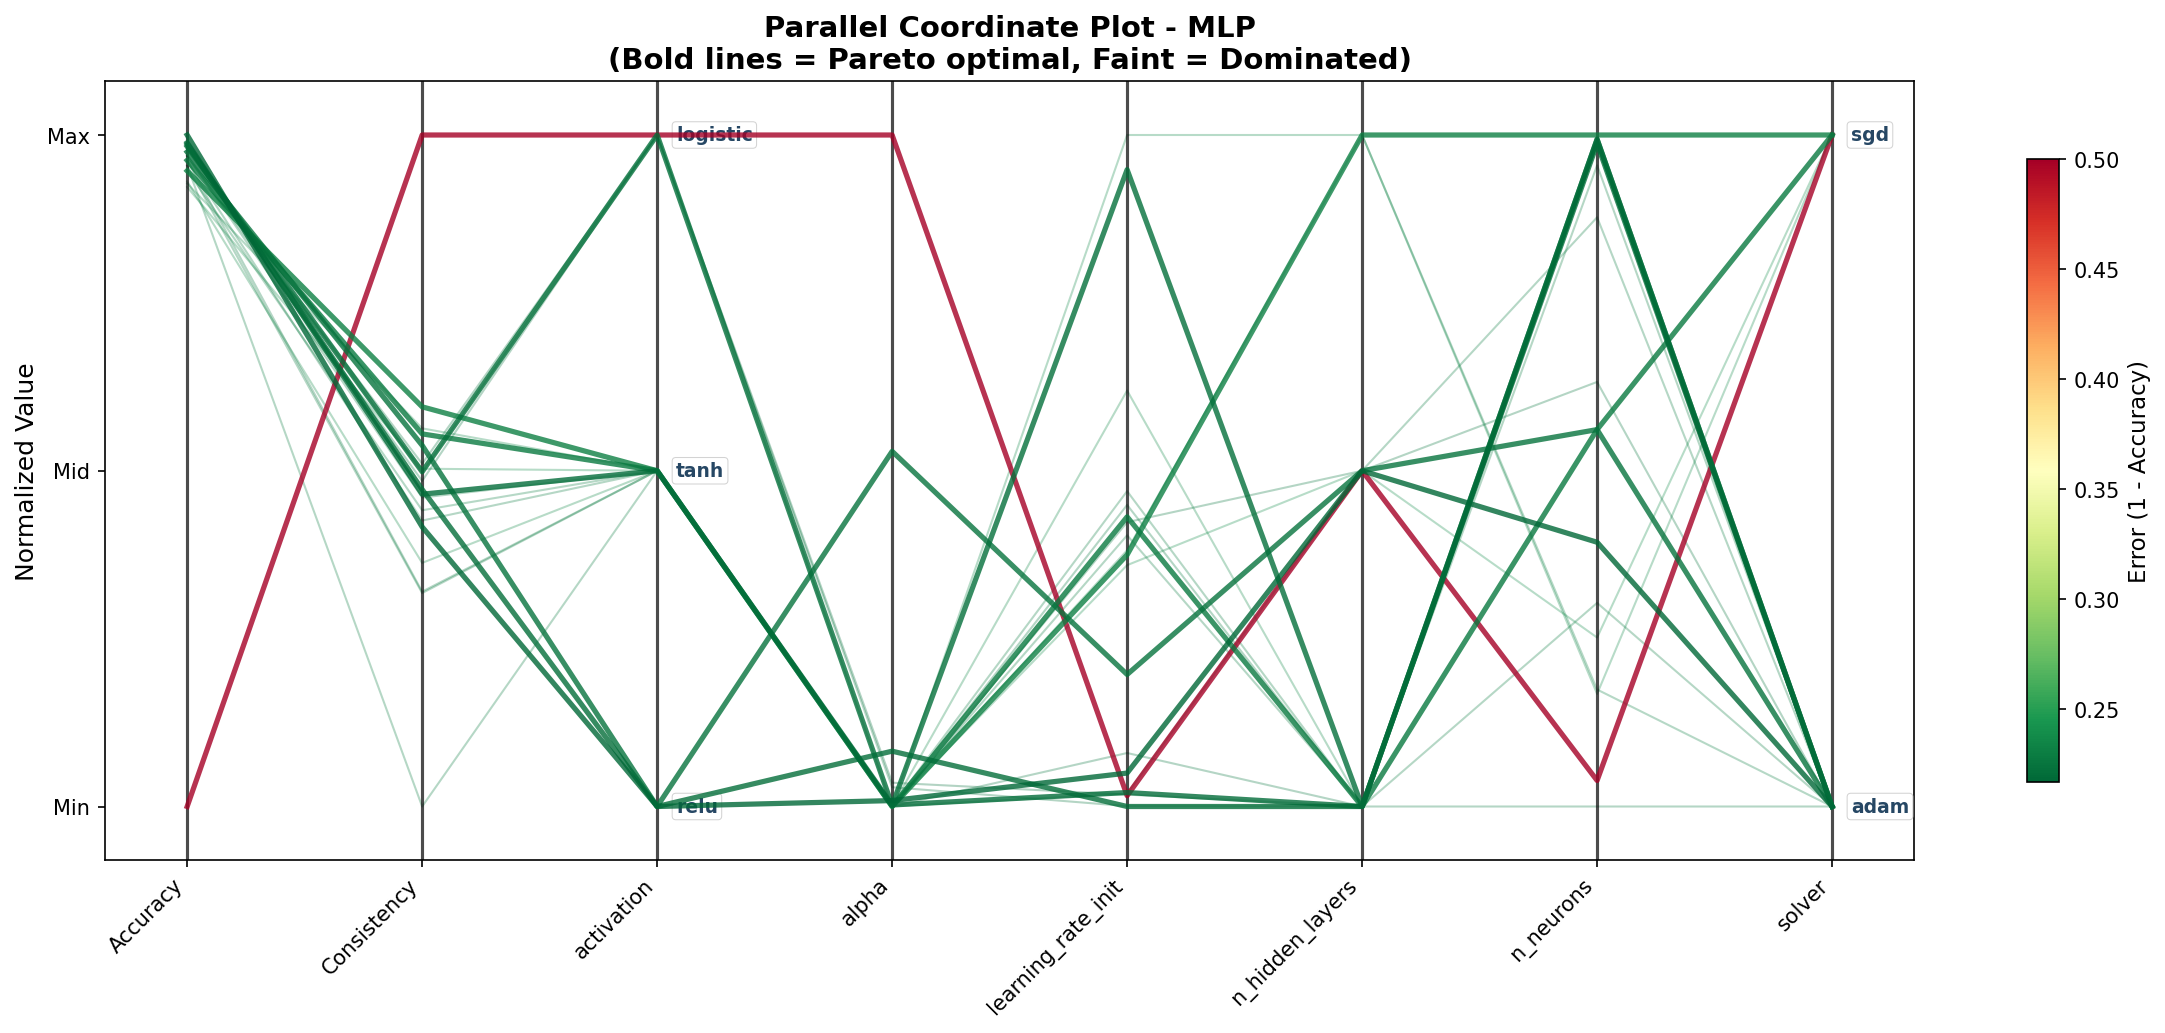

In [106]:
# MLP parallel coordinates (both notebook and latex versions)
mlp_parallel_filename = f"parallel_coords_{DATASET_NAME}_{SENSITIVE_FEATURE}_mlp.png"
mlp_parallel_paths = plot_parallel_coordinates(
    results['mlp'], 
    'mlp',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=mlp_parallel_filename,
    color_by='error',
    formats=["notebook", "latex"]
)

print("\nMLP - Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_paths["notebook"]))


### 3.3 MDS Projection

Multidimensional Scaling (MDS) projects the high-dimensional hyperparameter space into 2D while preserving pairwise distances between configurations.

| Element | Meaning |
|---------|---------|
| **Points** | Hyperparameter configurations |
| **Distance** | Similarity in hyperparameter values |
| **Background color** | Interpolated performance surface |
| **Red squares** | Pareto-optimal configurations |
| **White circles** | Non-Pareto configurations |

**Key insights:**
- Identify clusters of similar configurations
- See if high-performing configs are localized or spread out
- Understand the performance landscape structure

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_race_all_rf.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_race_all_rf.png

Random Forest - MDS Projection:


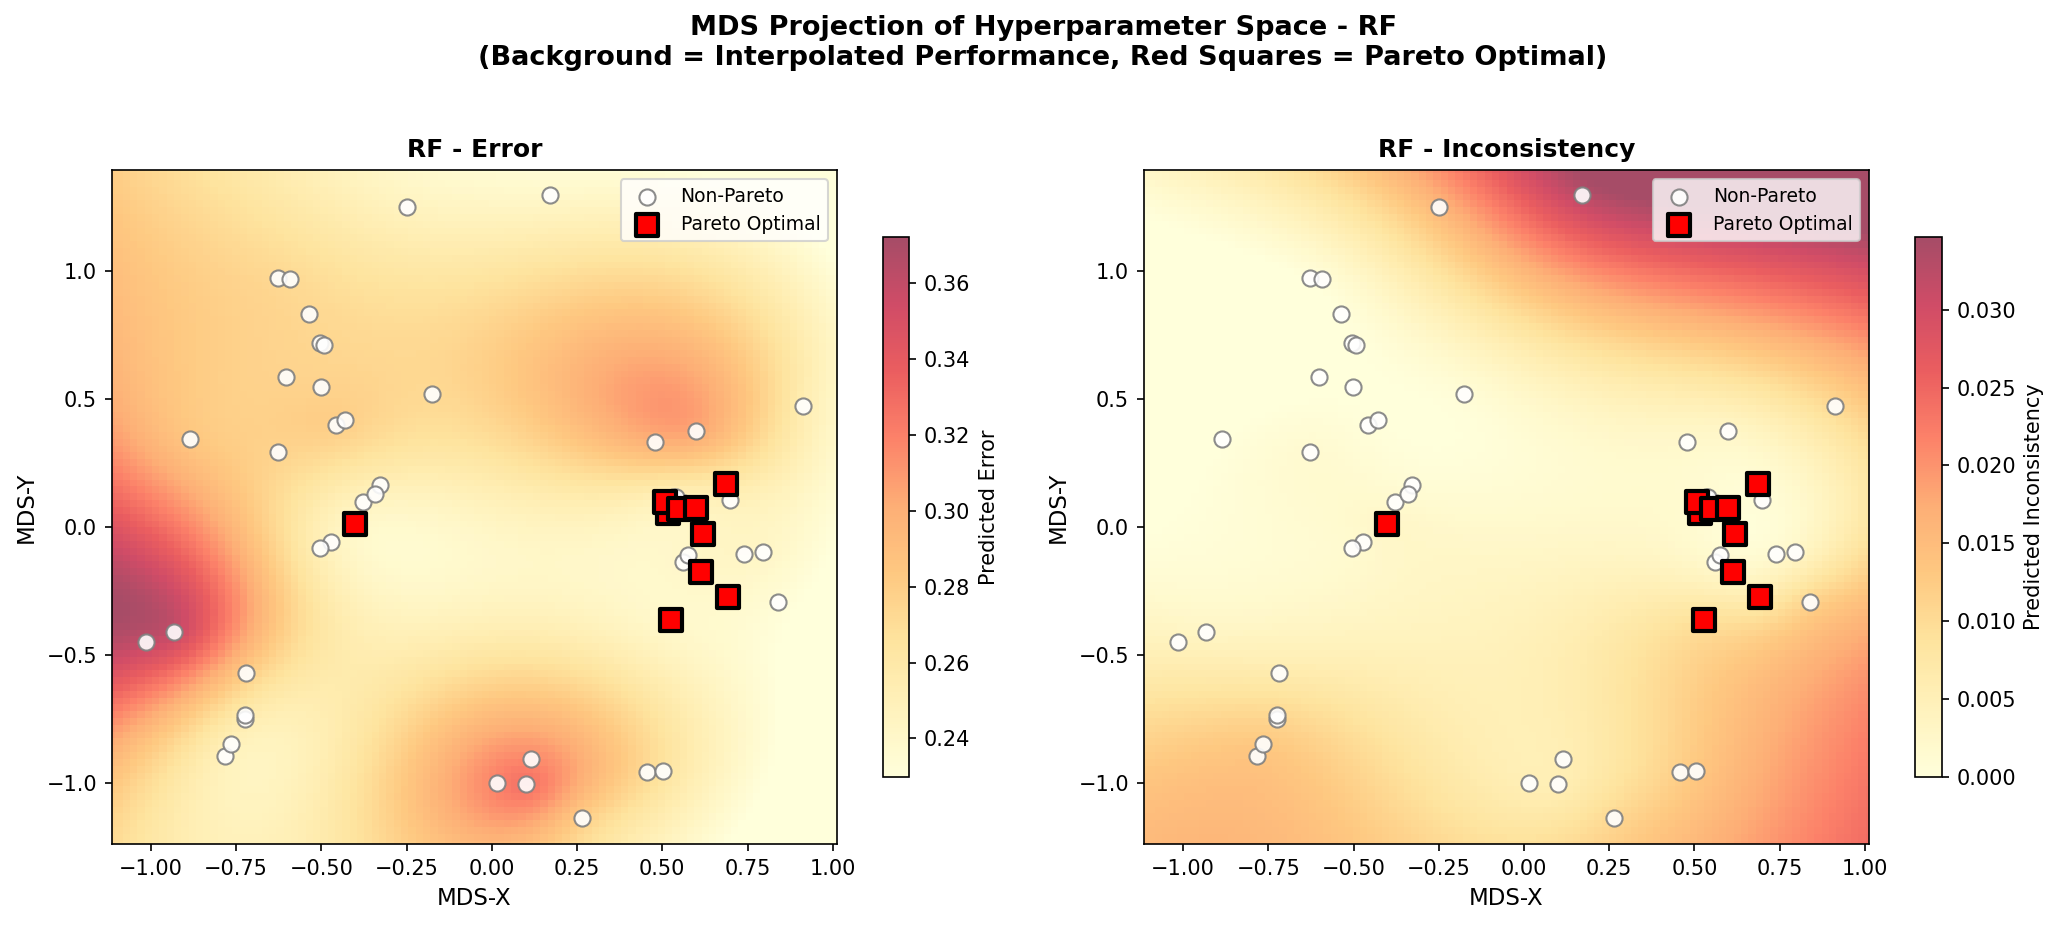

In [105]:
# Random Forest MDS projection (both notebook and latex versions)
rf_mds_filename = f"mds_projection_{DATASET_NAME}_{SENSITIVE_FEATURE}_rf.png"
rf_mds_paths = plot_mds_projection(
    results['rf'], 
    'rf',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=rf_mds_filename,
    formats=["notebook", "latex"]
)

print("\nRandom Forest - MDS Projection:")
display(Image(filename=rf_mds_paths["notebook"]))

MDS projection plot saved to: ../plots/mds_projection_adult_sex_mlp.png

MLP - MDS Projection:


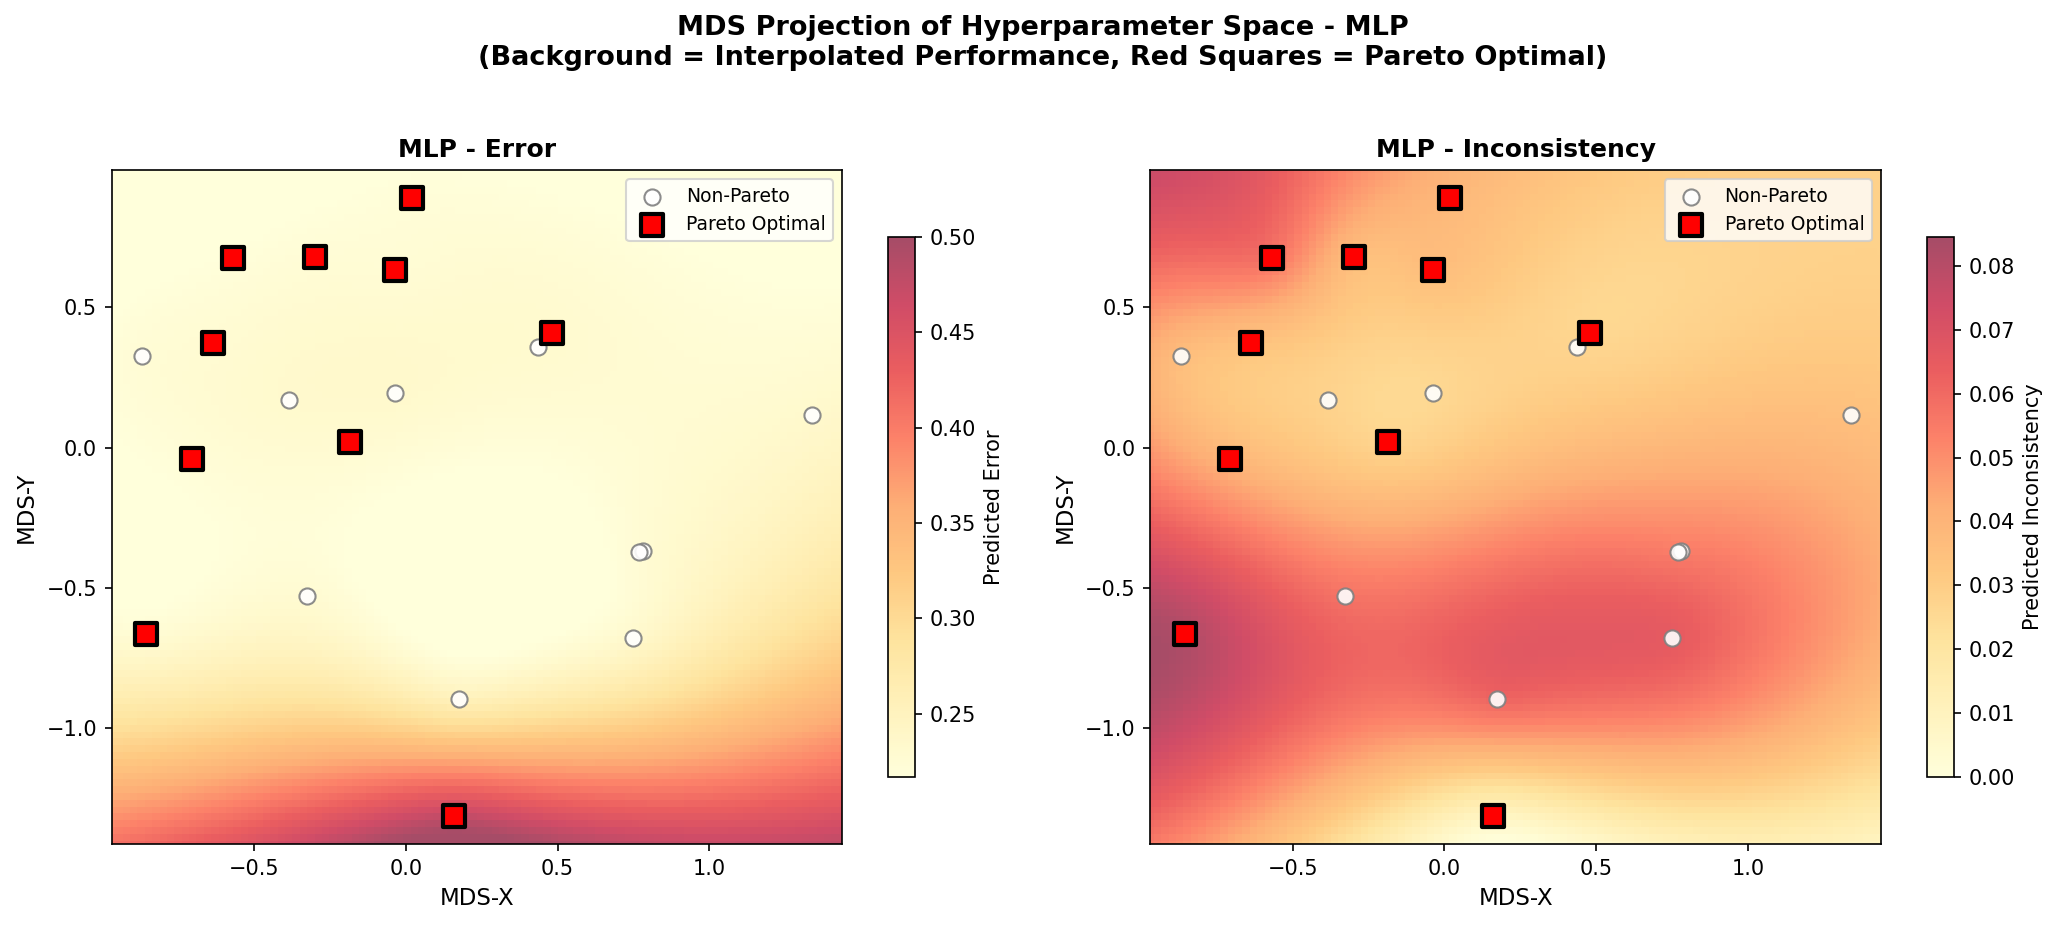

In [11]:
# MLP MDS projection
mlp_mds_path = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME}_{SENSITIVE_FEATURE}_mlp.png"
plot_mds_projection(results['mlp'], 'mlp', output_path=mlp_mds_path)

print("\nMLP - MDS Projection:")
display(Image(filename=mlp_mds_path))


### 3.4 Fairness-Accuracy Confusion Matrix

Analyzes the joint distribution of prediction correctness and counterfactual consistency at the sample level.

|                        | **Consistent** | **Inconsistent** |
|------------------------|----------------|------------------|
| **Correct Prediction** | ✅ Ideal | ⚠️ Right but Unfair |
| **Wrong Prediction**   | 🔸 Fair Error | ❌ Worst Case |

**Key metrics:**
- P(Consistent | Correct): Are correct predictions more likely to be fair?
- P(Correct | Inconsistent): Are unfair predictions more likely to be wrong?

This reveals whether fairness and accuracy are aligned or in tension for this model.


Analyzing RF - Best Accuracy Configuration
Config: {'criterion': np.str_('gini'), 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 134}
Accuracy: 0.7701
Consistency: 0.9866

FAIRNESS-ACCURACY CONFUSION MATRIX: RF (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction             38554             631      39185
Wrong Prediction                5590             447       6037
------------------------------------------------------------
Total                          44144            1078      45222

📈 Key Metrics:
  • Accuracy:    86.65%
  • Consistency: 97.62%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   98.39%
  • P(Consistent | Wrong):     92.60%
  • P(Correct | Consistent):   87.34%
  • P(Correct | Inconsistent): 58.53%

💡 Interpretation:
  → Correct predictions are 5.8% more likely to be co

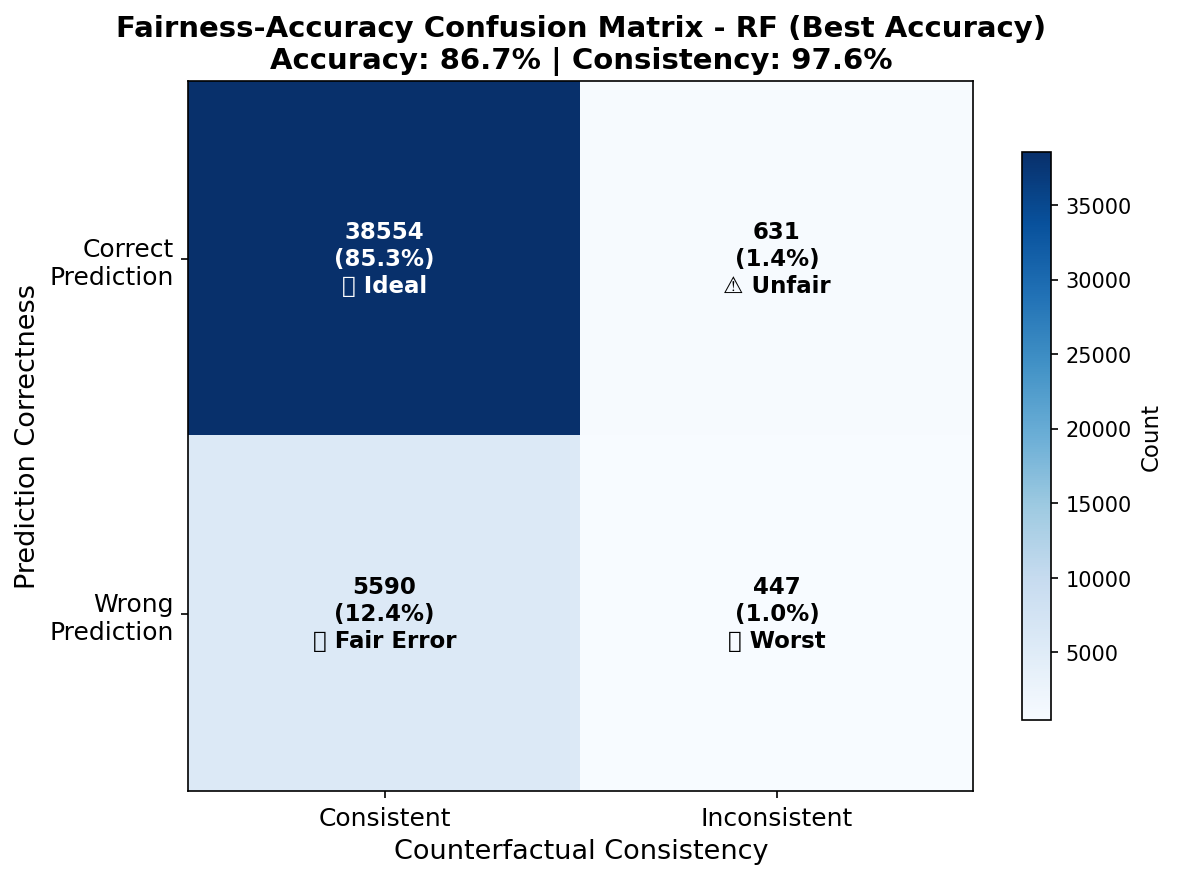


Analyzing MLP - Best Accuracy Configuration
Config: {'activation': np.str_('relu'), 'alpha': 0.0003343417908, 'learning_rate_init': 0.0048221759431, 'n_hidden_layers': 2, 'n_neurons': 82, 'solver': np.str_('adam')}
Accuracy: 0.7831
Consistency: 0.9624

FAIRNESS-ACCURACY CONFUSION MATRIX: MLP (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction             36758            2047      38805
Wrong Prediction                4913            1504       6417
------------------------------------------------------------
Total                          41671            3551      45222

📈 Key Metrics:
  • Accuracy:    85.81%
  • Consistency: 92.15%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   94.72%
  • P(Consistent | Wrong):     76.56%
  • P(Correct | Consistent):   88.21%
  • P(Correct | Inconsistent): 57.65%

💡 Interpretation:
  → Correct predictions are

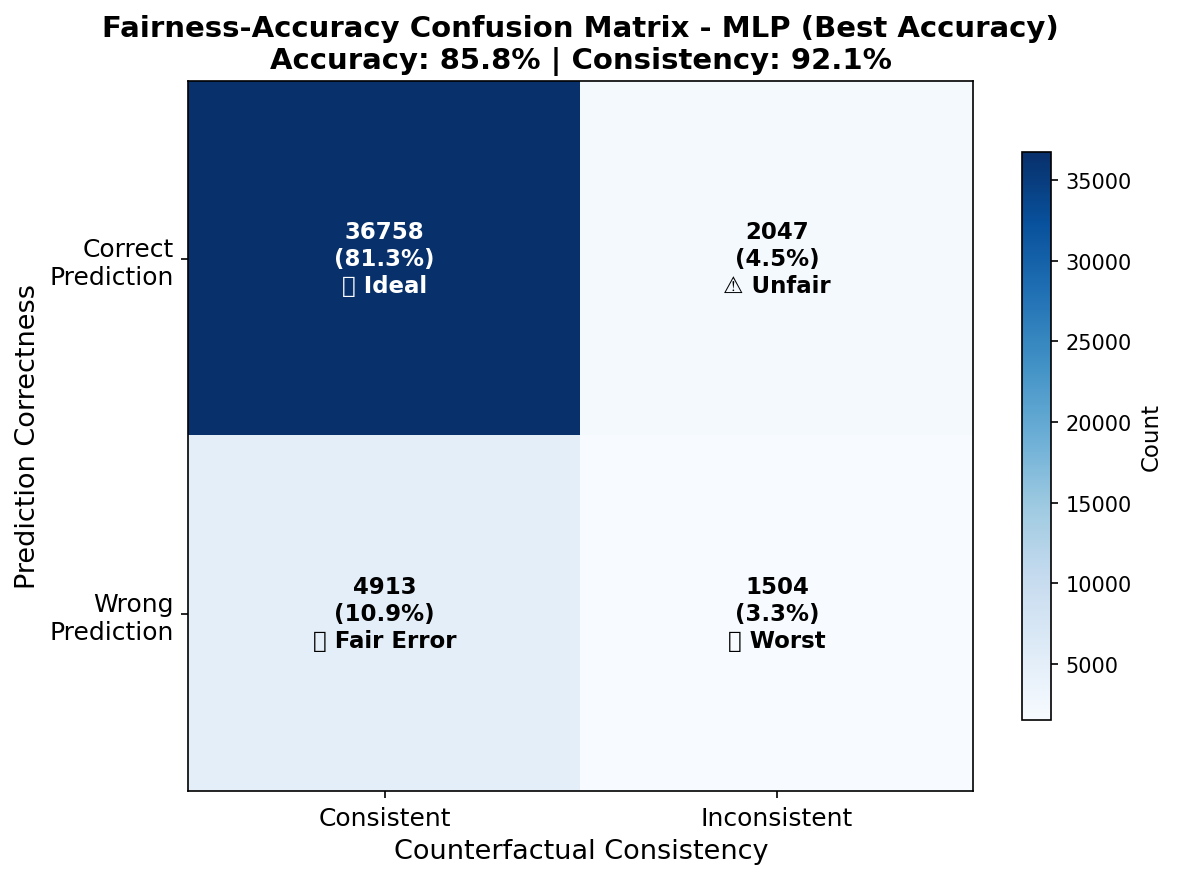

In [116]:
## 7. Fairness-Accuracy Confusion Matrix Analysis

# Analyze the relationship between correctness and consistency for each model
# Using the best accuracy configuration from the Pareto front

for model_type in ["rf", "mlp"]:
    print(f"\n{'='*70}")
    print(f"Analyzing {model_type.upper()} - Best Accuracy Configuration")
    print(f"{'='*70}")
    
    # Get best accuracy config from Pareto front
    configs, costs = get_pareto_front(results[model_type])
    best_acc_idx = np.argmin(costs[:, 0])  # Lowest error = best accuracy
    best_config = configs[best_acc_idx]
    
    print(f"Config: {dict(best_config)}")
    print(f"Accuracy: {1 - costs[best_acc_idx, 0]:.4f}")
    print(f"Consistency: {1 - costs[best_acc_idx, 1]:.4f}")
    
    # Create and train the model
    if model_type == "rf":
        model = create_rf_model(best_config)
    else:
        model = create_mlp_model(best_config)
    
    model.fit(data['X_train'], data['y_train'])
    
    # Compute fairness confusion matrix
    if data.get('is_multiclass', False):
        fcm_results = compute_fairness_confusion_matrix(
            model, data['X_train'], data['y_train'],
            sensitive_col_indices=data['sensitive_col_indices'],
            is_multiclass=True
        )
    else:
        fcm_results = compute_fairness_confusion_matrix(
            model, data['X_train'], data['y_train'],
            sensitive_col_idx=data['sensitive_col_idx'],
            is_multiclass=False
        )
    
    # Print summary
    print_fairness_confusion_summary(fcm_results, f"{model_type.upper()} (Best Accuracy)")
    
    # Plot and save
    fcm_paths = plot_fairness_confusion_matrix(
        fcm_results,
        model_name=f"{model_type.upper()} (Best Accuracy)",
        output_dir=OUTPUT_DIR,
        filename=f"fairness_confusion_{DATASET_NAME}_{SENSITIVE_FEATURE}_{model_type}_best_acc.png",
        formats=["notebook", "latex"]
    )
    
    # Display
    display(Image(filename=fcm_paths["notebook"]))

## 4. Analysis & Deep Dives

### 4.1 Investigating the "Trivially Fair" MLP

During optimization, SMAC found an MLP configuration achieving **100% consistency but only 50% accuracy**. This section investigates why this happens and confirms it's a degenerate solution.

In [117]:
# Investigate the "trivially fair" MLP configuration
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

# Get the fairest (but degenerate) MLP config from Pareto front
configs, costs = get_pareto_front(results['mlp'])
best_fair_idx = np.argmin(costs[:, 1])
fair_config = configs[best_fair_idx]

print("="*70)
print("TRIVIALLY FAIR MLP ANALYSIS")
print("="*70)

# The problematic configuration
fairest_config = {
    'hidden_layer_sizes': tuple([fair_config["n_neurons"]] * fair_config["n_hidden_layers"]),
    'activation': fair_config["activation"],
    'solver': fair_config["solver"],
    'alpha': fair_config["alpha"],
    'learning_rate_init': fair_config["learning_rate_init"],
    'max_iter': 500,
    'early_stopping': True,
    'random_state': 42
}

print(f"\nConfiguration: {fair_config['activation']} activation, {fair_config['solver']} solver")
print(f"Learning rate: {fair_config['learning_rate_init']:.4f}, Alpha: {fair_config['alpha']:.4f}")

# Train with original config (logistic/sigmoid activation)
model_logistic = MLPClassifier(**fairest_config)
model_logistic.fit(data['X_train'], data['y_train'])
y_pred_logistic = model_logistic.predict(data['X_train'])
acc_logistic = balanced_accuracy_score(data['y_train'], y_pred_logistic)

print(f"\n--- With LOGISTIC (sigmoid) activation ---")
print(f"Unique predictions: {np.unique(y_pred_logistic)} → Predicts only ONE class!")
print(f"Balanced Accuracy: {acc_logistic:.1%} (= random guessing)")
print(f"Training iterations: {model_logistic.n_iter_}")

# Now test with ReLU - the fix
relu_config = fairest_config.copy()
relu_config['activation'] = 'relu'

model_relu = MLPClassifier(**relu_config)
model_relu.fit(data['X_train'], data['y_train'])
y_pred_relu = model_relu.predict(data['X_train'])
acc_relu = balanced_accuracy_score(data['y_train'], y_pred_relu)

print(f"\n--- With ReLU activation (same other params) ---")
print(f"Unique predictions: {np.unique(y_pred_relu)} → Predicts BOTH classes!")
print(f"Balanced Accuracy: {acc_relu:.1%} (meaningful!)")
print(f"Training iterations: {model_relu.n_iter_}")

print(f"\n" + "="*70)
print("CONCLUSION:")
print("="*70)
print(f"→ Sigmoid activation caused vanishing gradients (gradient ≤ 0.25)")
print(f"→ Network never learned → constant predictions → 'trivial' 100% fairness")
print(f"→ ReLU fixes this: accuracy improves from {acc_logistic:.1%} to {acc_relu:.1%}")
print(f"\n⚠️  High fairness + low accuracy = likely a degenerate solution!")

TRIVIALLY FAIR MLP ANALYSIS

Configuration: logistic activation, sgd solver
Learning rate: 0.0017, Alpha: 0.0367

--- With LOGISTIC (sigmoid) activation ---
Unique predictions: [0] → Predicts only ONE class!
Balanced Accuracy: 50.0% (= random guessing)
Training iterations: 12

--- With ReLU activation (same other params) ---
Unique predictions: [0 1] → Predicts BOTH classes!
Balanced Accuracy: 77.4% (meaningful!)
Training iterations: 32

CONCLUSION:
→ Sigmoid activation caused vanishing gradients (gradient ≤ 0.25)
→ Network never learned → constant predictions → 'trivial' 100% fairness
→ ReLU fixes this: accuracy improves from 50.0% to 77.4%

⚠️  High fairness + low accuracy = likely a degenerate solution!


### Summary: The "Trivial Fairness" Problem

#### The Configuration

| Hyperparameter | Value | Impact |
|---------------|-------|--------|
| `activation` | `logistic` (sigmoid) | **Main culprit** - causes vanishing gradients |
| `solver` | `sgd` | No momentum to escape flat regions |
| `learning_rate_init` | ~0.002 | Very low - tiny weight updates |
| `alpha` | ~0.04 | High L2 regularization - pushes weights to zero |
| `hidden_layer_sizes` | 2 layers | Gradients multiply through both |

#### Root Cause: Vanishing Gradient Problem

The sigmoid activation function has a maximum gradient of only 0.25:

$$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x)) \leq 0.25$$

In a 2-layer network, gradients compound:

$$\text{Effective gradient} \approx 0.25 \times 0.25 = 0.0625 \text{ (6.25\% of original)}$$

#### Why This Matters for Fairness Research

This is a **false positive for fairness**: the model achieves perfect consistency not because it learned to be fair, but because it **learned nothing at all**. A constant predictor trivially satisfies:

$$\text{Consistency} = \frac{\sum \mathbb{1}[f(x) = f(x')]}{n} = 1.0 \quad \text{when } f(x) = c \text{ for all } x$$

#### Key Takeaway

> ⚠️ **When evaluating fairness metrics, always check model accuracy first.** A model with very high fairness but near-random accuracy may be a degenerate solution that provides no value.

#### Verification

Changing **only** the activation from `logistic` to `relu` (keeping all else the same) allows the network to learn:
- ReLU gradient = 1 (for positive inputs) vs sigmoid's max of 0.25
- The model achieves ~75% accuracy with the same hyperparameters
- This confirms the sigmoid activation was the bottleneck

## 📊 Case Study Analysis for Report

The following cells analyze specific samples to illustrate fairness concepts.


In [27]:
# Setup: Train both best accuracy models for comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np

# Best accuracy RF (from our optimization)
rf_model = RandomForestClassifier(
    n_estimators=66, max_depth=19, min_samples_split=14,
    min_samples_leaf=4, criterion='gini', random_state=42
)
rf_model.fit(X_train, y_train)

# Best accuracy MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(239,), activation='relu', solver='sgd',
    alpha=0.0174, learning_rate_init=0.0232, max_iter=1000,
    early_stopping=True, random_state=42
)
mlp_model.fit(X_train, y_train)

# Create flipped data (sex column)
from utils.datasets import create_flipped_data
X_train_flipped = create_flipped_data(X_train, data['sensitive_col_idx'])

# Get predictions for both original and flipped
rf_pred_orig = rf_model.predict(X_train)
rf_pred_flip = rf_model.predict(X_train_flipped)
rf_proba_orig = rf_model.predict_proba(X_train)[:, 1]
rf_proba_flip = rf_model.predict_proba(X_train_flipped)[:, 1]

mlp_pred_orig = mlp_model.predict(X_train)
mlp_pred_flip = mlp_model.predict(X_train_flipped)
mlp_proba_orig = mlp_model.predict_proba(X_train)[:, 1]
mlp_proba_flip = mlp_model.predict_proba(X_train_flipped)[:, 1]

# Find inconsistent samples for each model
rf_inconsistent = rf_pred_orig != rf_pred_flip
mlp_inconsistent = mlp_pred_orig != mlp_pred_flip

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"Total samples: {len(X_train)}")
print(f"RF inconsistent samples: {rf_inconsistent.sum()} ({100*rf_inconsistent.mean():.2f}%)")
print(f"MLP inconsistent samples: {mlp_inconsistent.sum()} ({100*mlp_inconsistent.mean():.2f}%)")


DATASET OVERVIEW
Total samples: 45222
RF inconsistent samples: 988 (2.18%)
MLP inconsistent samples: 4345 (9.61%)


In [29]:
# ============================================================================
# CASE STUDY 1: Sample where changing sex FLIPS the prediction
# ============================================================================
# Find a sample where RF prediction changes when sex is flipped

# Get feature names for interpretation
feature_names = list(X_train.columns) if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Find inconsistent sample indices
rf_flip_indices = np.where(rf_inconsistent)[0]

if len(rf_flip_indices) > 0:
    # Pick one example
    idx = rf_flip_indices[0]
    
    print("=" * 70)
    print("CASE STUDY 1: Prediction Flip When Sex Changes (RF Model)")
    print("=" * 70)
    print(f"\nSample Index: {idx}")
    print(f"True Label: {'High Income (>50K)' if y_train[idx] == 1 else 'Low Income (<=50K)'}")
    
    print(f"\n--- Original Sample ---")
    print(f"Prediction: {'High Income' if rf_pred_orig[idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_orig[idx]:.4f}")
    
    print(f"\n--- After Flipping Sex ---")
    print(f"Prediction: {'High Income' if rf_pred_flip[idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_flip[idx]:.4f}")
    
    print(f"\n--- Probability Change ---")
    print(f"ΔP = {rf_proba_flip[idx] - rf_proba_orig[idx]:.4f}")
    
    # Show the sex feature value
    sex_col_idx = [i for i, name in enumerate(feature_names) if 'sex' in name.lower()]
    if sex_col_idx:
        orig_val = X_train.iloc[idx, sex_col_idx[0]] if hasattr(X_train, 'iloc') else X_train[idx, sex_col_idx[0]]
        flip_val = X_train_flipped[idx, sex_col_idx[0]] if isinstance(X_train_flipped, np.ndarray) else X_train_flipped.iloc[idx, sex_col_idx[0]]
        print(f"\nSex feature '{feature_names[sex_col_idx[0]]}': {orig_val} → {flip_val}")
else:
    print("No inconsistent samples found for RF!")


CASE STUDY 1: Prediction Flip When Sex Changes (RF Model)

Sample Index: 4
True Label: Low Income (<=50K)

--- Original Sample ---
Prediction: High Income
Confidence P(High Income): 0.5407

--- After Flipping Sex ---
Prediction: Low Income
Confidence P(High Income): 0.4959

--- Probability Change ---
ΔP = -0.0448


In [30]:
# ============================================================================
# CASE STUDY 2: Sample that STAYS CONSISTENT (for contrast)
# ============================================================================
# Find a sample where prediction stays the same when sex is flipped

rf_consistent_indices = np.where(~rf_inconsistent)[0]

if len(rf_consistent_indices) > 0:
    # Pick a high-confidence consistent sample
    consistent_proba = rf_proba_orig[rf_consistent_indices]
    # Find one with high confidence (far from 0.5)
    high_conf_idx = rf_consistent_indices[np.argmax(np.abs(consistent_proba - 0.5))]
    
    print("\n" + "=" * 70)
    print("CASE STUDY 2: Consistent Prediction (Sex Change Has No Effect)")
    print("=" * 70)
    print(f"\nSample Index: {high_conf_idx}")
    print(f"True Label: {'High Income' if y_train[high_conf_idx] == 1 else 'Low Income'}")
    
    print(f"\n--- Original Sample ---")
    print(f"Prediction: {'High Income' if rf_pred_orig[high_conf_idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_orig[high_conf_idx]:.4f}")
    
    print(f"\n--- After Flipping Sex ---")
    print(f"Prediction: {'High Income' if rf_pred_flip[high_conf_idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_flip[high_conf_idx]:.4f}")
    
    print(f"\n✓ This sample's prediction is ROBUST to sex changes")
    print(f"  The model relies on other features (education, occupation, etc.)")



CASE STUDY 2: Consistent Prediction (Sex Change Has No Effect)

Sample Index: 28345
True Label: Low Income

--- Original Sample ---
Prediction: Low Income
Confidence P(High Income): 0.0000

--- After Flipping Sex ---
Prediction: Low Income
Confidence P(High Income): 0.0023

✓ This sample's prediction is ROBUST to sex changes
  The model relies on other features (education, occupation, etc.)


In [31]:
# ============================================================================
# CASE STUDY 3: Edge Case - Sample NEAR Decision Boundary
# ============================================================================
# Find samples where probability is close to 0.5 (uncertain predictions)

boundary_dist = np.abs(rf_proba_orig - 0.5)
near_boundary = boundary_dist < 0.1  # Within 10% of boundary

print("\n" + "=" * 70)
print("CASE STUDY 3: Edge Cases Near Decision Boundary")
print("=" * 70)

print(f"\nSamples within 10% of decision boundary: {near_boundary.sum()}")
print(f"Of these, inconsistent when sex flipped: {(near_boundary & rf_inconsistent).sum()}")
print(f"Inconsistency rate near boundary: {100*(near_boundary & rf_inconsistent).sum()/near_boundary.sum():.1f}%")
print(f"Inconsistency rate overall: {100*rf_inconsistent.mean():.1f}%")

# Pick an edge case example
edge_indices = np.where(near_boundary & rf_inconsistent)[0]
if len(edge_indices) > 0:
    edge_idx = edge_indices[0]
    print(f"\n--- Example Edge Case (Index {edge_idx}) ---")
    print(f"Original P(High Income): {rf_proba_orig[edge_idx]:.4f} (very uncertain!)")
    print(f"Flipped P(High Income):  {rf_proba_flip[edge_idx]:.4f}")
    print(f"Prediction: {'High Income' if rf_pred_orig[edge_idx] == 1 else 'Low Income'} → {'High Income' if rf_pred_flip[edge_idx] == 1 else 'Low Income'}")
    print(f"\n→ Edge cases are MORE vulnerable to bias - small changes flip predictions!")



CASE STUDY 3: Edge Cases Near Decision Boundary

Samples within 10% of decision boundary: 4987
Of these, inconsistent when sex flipped: 986
Inconsistency rate near boundary: 19.8%
Inconsistency rate overall: 2.2%

--- Example Edge Case (Index 4) ---
Original P(High Income): 0.5407 (very uncertain!)
Flipped P(High Income):  0.4959
Prediction: High Income → Low Income

→ Edge cases are MORE vulnerable to bias - small changes flip predictions!


In [32]:
# ============================================================================
# CASE STUDY 4: RF vs MLP on SAME Sample
# ============================================================================
# Find a sample where models disagree on consistency

rf_only_inconsistent = rf_inconsistent & ~mlp_inconsistent
mlp_only_inconsistent = ~rf_inconsistent & mlp_inconsistent
both_inconsistent = rf_inconsistent & mlp_inconsistent

print("\n" + "=" * 70)
print("CASE STUDY 4: Comparing RF vs MLP Fairness on Same Samples")
print("=" * 70)

print(f"\nOnly RF inconsistent: {rf_only_inconsistent.sum()}")
print(f"Only MLP inconsistent: {mlp_only_inconsistent.sum()}")
print(f"Both models inconsistent: {both_inconsistent.sum()}")
print(f"Both models consistent: {(~rf_inconsistent & ~mlp_inconsistent).sum()}")

# Example where RF is unfair but MLP is fair
if rf_only_inconsistent.sum() > 0:
    idx = np.where(rf_only_inconsistent)[0][0]
    print(f"\n--- Sample {idx}: RF Unfair, MLP Fair ---")
    print(f"RF:  P={rf_proba_orig[idx]:.3f} → {rf_proba_flip[idx]:.3f} | Pred: {rf_pred_orig[idx]} → {rf_pred_flip[idx]} ✗")
    print(f"MLP: P={mlp_proba_orig[idx]:.3f} → {mlp_proba_flip[idx]:.3f} | Pred: {mlp_pred_orig[idx]} → {mlp_pred_flip[idx]} ✓")

# Example where MLP is unfair but RF is fair
if mlp_only_inconsistent.sum() > 0:
    idx = np.where(mlp_only_inconsistent)[0][0]
    print(f"\n--- Sample {idx}: MLP Unfair, RF Fair ---")
    print(f"RF:  P={rf_proba_orig[idx]:.3f} → {rf_proba_flip[idx]:.3f} | Pred: {rf_pred_orig[idx]} → {rf_pred_flip[idx]} ✓")
    print(f"MLP: P={mlp_proba_orig[idx]:.3f} → {mlp_proba_flip[idx]:.3f} | Pred: {mlp_pred_orig[idx]} → {mlp_pred_flip[idx]} ✗")

print("\n→ Different models can be unfair to DIFFERENT individuals!")



CASE STUDY 4: Comparing RF vs MLP Fairness on Same Samples

Only RF inconsistent: 298
Only MLP inconsistent: 3655
Both models inconsistent: 690
Both models consistent: 40579

--- Sample 4: RF Unfair, MLP Fair ---
RF:  P=0.541 → 0.496 | Pred: 1 → 0 ✗
MLP: P=0.573 → 0.752 | Pred: 1 → 1 ✓

--- Sample 10: MLP Unfair, RF Fair ---
RF:  P=0.563 → 0.528 | Pred: 1 → 1 ✓
MLP: P=0.626 → 0.408 | Pred: 1 → 0 ✗

→ Different models can be unfair to DIFFERENT individuals!


In [33]:
# ============================================================================
# CASE STUDY 5: Largest Probability Swing
# ============================================================================
# Find the sample with the largest change in probability when sex is flipped

rf_proba_change = np.abs(rf_proba_flip - rf_proba_orig)
mlp_proba_change = np.abs(mlp_proba_flip - mlp_proba_orig)

print("\n" + "=" * 70)
print("CASE STUDY 5: Largest Probability Swings")
print("=" * 70)

# RF largest swing
rf_max_idx = np.argmax(rf_proba_change)
print(f"\n--- RF: Largest Probability Change ---")
print(f"Sample Index: {rf_max_idx}")
print(f"P(High Income): {rf_proba_orig[rf_max_idx]:.4f} → {rf_proba_flip[rf_max_idx]:.4f}")
print(f"Change: {rf_proba_change[rf_max_idx]:.4f} ({100*rf_proba_change[rf_max_idx]:.1f}%)")
print(f"Prediction flipped: {'Yes ✗' if rf_inconsistent[rf_max_idx] else 'No ✓'}")

# MLP largest swing
mlp_max_idx = np.argmax(mlp_proba_change)
print(f"\n--- MLP: Largest Probability Change ---")
print(f"Sample Index: {mlp_max_idx}")
print(f"P(High Income): {mlp_proba_orig[mlp_max_idx]:.4f} → {mlp_proba_flip[mlp_max_idx]:.4f}")
print(f"Change: {mlp_proba_change[mlp_max_idx]:.4f} ({100*mlp_proba_change[mlp_max_idx]:.1f}%)")
print(f"Prediction flipped: {'Yes ✗' if mlp_inconsistent[mlp_max_idx] else 'No ✓'}")

print(f"\n→ Even without flipping predictions, large probability changes indicate sensitivity to sex!")



CASE STUDY 5: Largest Probability Swings

--- RF: Largest Probability Change ---
Sample Index: 26658
P(High Income): 0.2724 → 0.4551
Change: 0.1827 (18.3%)
Prediction flipped: No ✓

--- MLP: Largest Probability Change ---
Sample Index: 5968
P(High Income): 0.6971 → 0.3648
Change: 0.3323 (33.2%)
Prediction flipped: Yes ✗

→ Even without flipping predictions, large probability changes indicate sensitivity to sex!


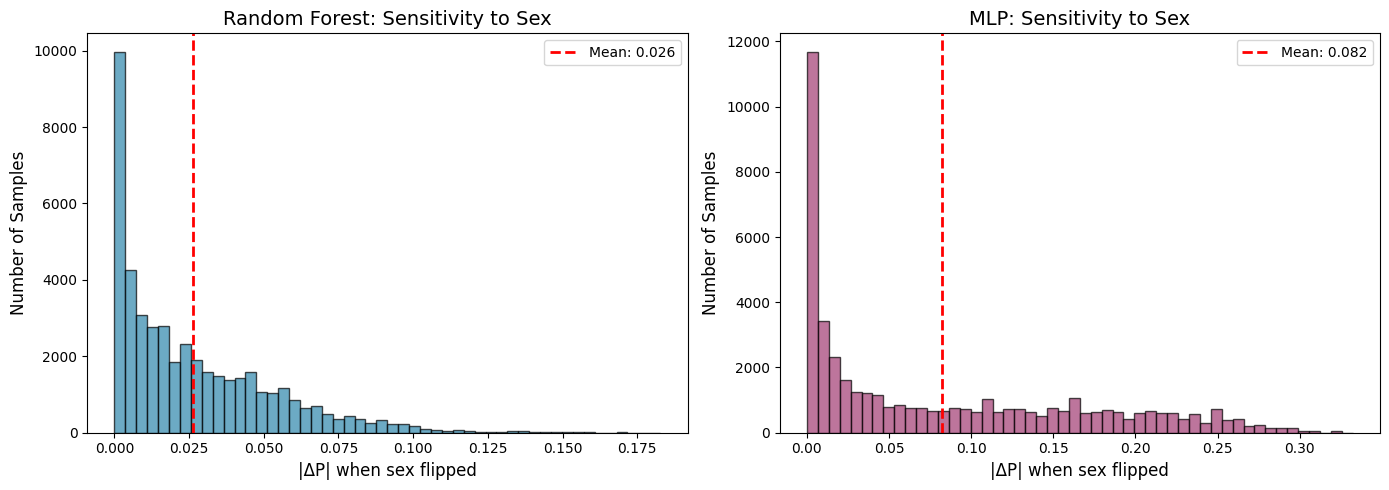

RF  - Mean |ΔP|: 0.0263, Max: 0.1827
MLP - Mean |ΔP|: 0.0825, Max: 0.3323


In [34]:
# ============================================================================
# VISUALIZATION: Probability Change Distribution
# ============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RF probability change distribution
axes[0].hist(rf_proba_change, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0].axvline(x=rf_proba_change.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {rf_proba_change.mean():.3f}')
axes[0].set_xlabel('|ΔP| when sex flipped', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Random Forest: Sensitivity to Sex', fontsize=14)
axes[0].legend()

# MLP probability change distribution
axes[1].hist(mlp_proba_change, bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[1].axvline(x=mlp_proba_change.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mlp_proba_change.mean():.3f}')
axes[1].set_xlabel('|ΔP| when sex flipped', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('MLP: Sensitivity to Sex', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.savefig('../plots/probability_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"RF  - Mean |ΔP|: {rf_proba_change.mean():.4f}, Max: {rf_proba_change.max():.4f}")
print(f"MLP - Mean |ΔP|: {mlp_proba_change.mean():.4f}, Max: {mlp_proba_change.max():.4f}")


In [ ]:
# ============================================================================
# VISUALIZATION: Original vs Flipped Probability Scatter
# ============================================================================
# This is a powerful visualization showing how predictions change

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RF scatter
scatter1 = axes[0].scatter(rf_proba_orig, rf_proba_flip, 
                           c=rf_inconsistent.astype(int), cmap='coolwarm',
                           alpha=0.5, s=10)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect consistency')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('P(High Income) - Original', fontsize=12)
axes[0].set_ylabel('P(High Income) - Sex Flipped', fontsize=12)
axes[0].set_title('Random Forest: Counterfactual Analysis', fontsize=14)
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# MLP scatter
scatter2 = axes[1].scatter(mlp_proba_orig, mlp_proba_flip,
                           c=mlp_inconsistent.astype(int), cmap='coolwarm',
                           alpha=0.5, s=10)
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect consistency')
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('P(High Income) - Original', fontsize=12)
axes[1].set_ylabel('P(High Income) - Sex Flipped', fontsize=12)
axes[1].set_title('MLP: Counterfactual Analysis', fontsize=14)
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

# Add colorbar
cbar = plt.colorbar(scatter2, ax=axes[1])
cbar.set_label('Prediction Flipped', fontsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
plt.savefig('../plots/counterfactual_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Blue points = consistent predictions (fair)")
print("Red points = prediction flipped when sex changed (unfair)")
print("\nPoints in upper-left or lower-right quadrants crossed the decision boundary!")


In [ ]:
# ============================================================================
# SUMMARY TABLE: Key Case Studies for Report
# ============================================================================

# Create a summary dataframe of interesting samples
case_studies = []

# Case 1: RF flip example
if len(rf_flip_indices) > 0:
    idx = rf_flip_indices[0]
    case_studies.append({
        'Case': '1. RF Prediction Flip',
        'Sample ID': idx,
        'Model': 'RF',
        'P(orig)': f'{rf_proba_orig[idx]:.3f}',
        'P(flip)': f'{rf_proba_flip[idx]:.3f}',
        'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
        'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
        'Insight': 'Direct discrimination example'
    })

# Case 2: Consistent high-confidence
if len(rf_consistent_indices) > 0:
    idx = high_conf_idx
    case_studies.append({
        'Case': '2. RF Consistent',
        'Sample ID': idx,
        'Model': 'RF',
        'P(orig)': f'{rf_proba_orig[idx]:.3f}',
        'P(flip)': f'{rf_proba_flip[idx]:.3f}',
        'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
        'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
        'Insight': 'Robust to sensitive feature'
    })

# Case 3: Edge case
if len(edge_indices) > 0:
    idx = edge_idx
    case_studies.append({
        'Case': '3. Edge Case',
        'Sample ID': idx,
        'Model': 'RF',
        'P(orig)': f'{rf_proba_orig[idx]:.3f}',
        'P(flip)': f'{rf_proba_flip[idx]:.3f}',
        'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
        'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
        'Insight': 'Near boundary - vulnerable'
    })

# Case 4: Largest RF swing
idx = rf_max_idx
case_studies.append({
    'Case': '4. Largest ΔP (RF)',
    'Sample ID': idx,
    'Model': 'RF',
    'P(orig)': f'{rf_proba_orig[idx]:.3f}',
    'P(flip)': f'{rf_proba_flip[idx]:.3f}',
    'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
    'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
    'Insight': 'Maximum sensitivity'
})

# Case 5: Largest MLP swing
idx = mlp_max_idx
case_studies.append({
    'Case': '5. Largest ΔP (MLP)',
    'Sample ID': idx,
    'Model': 'MLP',
    'P(orig)': f'{mlp_proba_orig[idx]:.3f}',
    'P(flip)': f'{mlp_proba_flip[idx]:.3f}',
    'ΔP': f'{mlp_proba_flip[idx] - mlp_proba_orig[idx]:+.3f}',
    'Pred Change': f'{mlp_pred_orig[idx]}→{mlp_pred_flip[idx]}',
    'Insight': 'Maximum sensitivity'
})

df_cases = pd.DataFrame(case_studies)
print("\n" + "=" * 90)
print("SUMMARY TABLE: Key Case Studies for Report")
print("=" * 90)
display(df_cases)

# Save to CSV for report
df_cases.to_csv('../plots/case_studies_summary.csv', index=False)
print("\n✓ Summary saved to plots/case_studies_summary.csv")


---

# Approach 2: Models WITHOUT Sensitive Features + SenSeI

In this section, we compare models trained **without sensitive features** (sex, race removed):

**Models compared:**
1. **Random Forest** - trained without sex/race, evaluated on proxy
2. **MLP** - trained without sex/race, evaluated on proxy  
3. **SenSeI** - IBM's individual fairness model with Lipschitz constraint

**Key differences from Approach 1:**
- Sensitive features (sex_Male, race_White) are **removed** from all models
- SenSeI uses these removed features to learn a **fair distance metric**
- Counterfactual consistency is evaluated on **proxy feature** (`relationship_Wife`)

**Why relationship_Wife?**
- `relationship_Wife` is a strong proxy for gender (Wife → Female)
- This tests if models can still discriminate via correlated features
- This is the same evaluation metric IBM uses in their `inFairness` examples


In [42]:
# Import Approach 2 functions
from main import (
    main_approach2,
    run_optimization,
    SENSEI_AVAILABLE,
)

# Check if SenSeI is available
print("=" * 60)
print("APPROACH 2: Setup")
print("=" * 60)
print(f"SenSeI available: {SENSEI_AVAILABLE}")
if not SENSEI_AVAILABLE:
    print("⚠️  Install inFairness for SenSeI: pip install inFairness")
    print("   Will run RF and MLP without SenSeI comparison")


APPROACH 2: Setup
SenSeI available: True


In [64]:
# Approach 2 Configuration
DATASET_NAME_A2 = "adult"
SENSITIVE_FEATURES_TO_REMOVE = ["sex", "race"]  # Features to remove from training
PROXY_FEATURE = "relationship"  # Proxy for counterfactual (uses relationship_Wife)

# Use same time limits as Approach 1
WALLTIME_LIMIT_A2 = 600
N_TRIALS_A2 = 150

# Whether to include SenSeI (set to False to skip if it's slow or unavailable)
INCLUDE_SENSEI = SENSEI_AVAILABLE

print("=" * 60)
print("APPROACH 2 Configuration")
print("=" * 60)
print(f"  Dataset: {DATASET_NAME_A2}")
print(f"  Sensitive features REMOVED: {SENSITIVE_FEATURES_TO_REMOVE}")
print(f"  Proxy feature for counterfactual: {PROXY_FEATURE}")
print(f"  Time limit per model: {WALLTIME_LIMIT_A2}s")
print(f"  Max trials per model: {N_TRIALS_A2}")
print(f"  Include SenSeI: {INCLUDE_SENSEI}")


APPROACH 2 Configuration
  Dataset: adult
  Sensitive features REMOVED: ['sex', 'race']
  Proxy feature for counterfactual: relationship
  Time limit per model: 600s
  Max trials per model: 150
  Include SenSeI: True


In [65]:
# Load dataset for Approach 2 (without sensitive features)
data_a2 = load_dataset(
    DATASET_NAME_A2,
    approach=2,
    sensitive_features_to_remove=SENSITIVE_FEATURES_TO_REMOVE,
    proxy_feature=PROXY_FEATURE,
)

print("\n" + "=" * 60)
print("APPROACH 2: Data Summary")
print("=" * 60)
print(f"  X_train shape: {data_a2['X_train'].shape}")
print(f"  y_train distribution: {np.bincount(data_a2['y_train'])}")
print(f"  Proxy column: {data_a2['proxy_col_name']} (index {data_a2['proxy_col_idx']})")
if data_a2['X_protected'] is not None:
    print(f"  X_protected shape: {data_a2['X_protected'].shape}")
    print(f"  Protected features: {data_a2['protected_feature_names']}")


Loading Adult Income from OpenML (ID: 179)...
APPROACH 2: Removing sensitive features from training
  Sensitive features to remove: ['sex', 'race']
  Proxy feature for counterfactual: relationship
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Protected features (for SenSeI): ['sex_Male', 'race_White']
Proxy column for counterfactual: relationship_Wife (index 35)

Final features (56): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 2):
  Samples: 45222, Features: 56
  Positive class ratio: 24.78%

APPROACH 2: Data Summary
  X_train shape: (45222, 56)
  y_train distribution: [34014 11208]
  Proxy column: relationship_Wife (index 35)
  X_protect

In [ ]:
%%time

# Run optimization for Approach 2 models OR load from cache
if LOAD_FROM_CACHE:
    print("Loading Approach 2 results from cache...")
    results_a2 = load_smac_results(DATASET_NAME_A2, f"{PROXY_FEATURE}_approach2", approach=2)
else:
    print("Running SMAC optimization for Approach 2...")
    results_a2 = {}
    
    # Standard models without sensitive features
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()} (Approach 2 - No Sensitive Features)...")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data_a2,
            walltime_limit=WALLTIME_LIMIT_A2 // 2,
            n_trials=N_TRIALS_A2 // 2,
            output_dir="../smac_output",
            approach=2,
        )
        results_a2[model_type] = smac
    
    # SenSeI (if available and requested)
    if INCLUDE_SENSEI:
        print(f"\n{'='*60}")
        print(f"Optimizing SenSeI (Approach 2 - Individual Fairness Training)...")
        print(f"{'='*60}")
        
        try:
            smac_sensei = run_optimization(
                model_type="sensei",
                data=data_a2,
                walltime_limit=WALLTIME_LIMIT_A2 * 2,
                n_trials=N_TRIALS_A2 * 2,
                output_dir="../smac_output",
                approach=2,
            )
            results_a2["sensei"] = smac_sensei
        except Exception as e:
            print(f"⚠️  SenSeI optimization failed: {e}")
            print("   Continuing with RF and MLP only.")
    
    print("\n" + "="*60)
    print("Approach 2 Optimization complete!")
    print(f"Models optimized: {list(results_a2.keys())}")
    print("="*60)
    
    # Save results to cache for future use
    save_smac_results(results_a2, DATASET_NAME_A2, f"{PROXY_FEATURE}_approach2", approach=2)


Optimizing RF (Approach 2 - No Sensitive Features)...

Running SMAC optimization for RF (Approach 2)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:596] Added config 31471b and rejected config 5a799a as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:604] Config 864316 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:604] Config 7e38f9 is a new incumbent. Total number of incumbents: 5.
[INFO][abstract

In [57]:
# Print Pareto summary for Approach 2
print_pareto_summary(results_a2)




PARETO FRONT SUMMARY

RF Pareto Front (8 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7693, Consistency=0.9838
  Config 2: Accuracy=0.7593, Consistency=0.9953
  Config 3: Accuracy=0.7591, Consistency=0.9960
  Config 4: Accuracy=0.7589, Consistency=0.9966
  Config 5: Accuracy=0.7576, Consistency=0.9977
  Config 6: Accuracy=0.7530, Consistency=0.9986
  Config 7: Accuracy=0.7318, Consistency=1.0000
  Config 8: Accuracy=0.7294, Consistency=1.0000

  Best Accuracy: 0.7693 (Consistency: 0.9838)
  Best Consistency: 1.0000 (Accuracy: 0.7294)

MLP Pareto Front (5 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7786, Consistency=0.9178
  Config 2: Accuracy=0.7780, Consistency=0.9315
  Config 3: Accuracy=0.7749, Consistency=0.9333
  Config 4: Accuracy=0.7739, Consistency=0.9583
  Config 5: Accuracy=0.5000, Consistency=1.0000

  Best Accuracy: 0.7786 (Consistency: 0.9178)
  Best Consistency: 1.0000 (Accuracy:

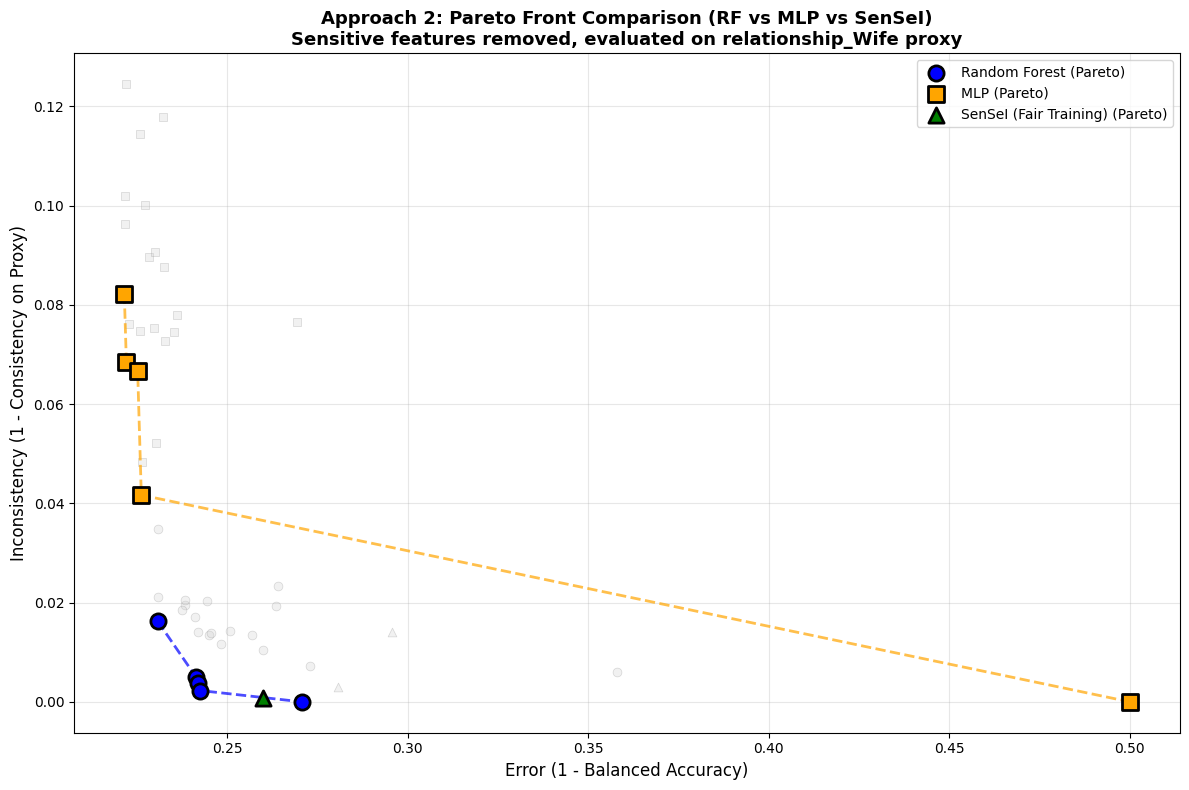

Plot saved to: ../plots/pareto_adult_approach2_with_sensei.png


In [70]:
# If SenSeI was optimized, create a combined Pareto plot including all 3 models
if "sensei" in results_a2:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
    markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}
    labels = {'rf': 'Random Forest', 'mlp': 'MLP', 'sensei': 'SenSeI (Fair Training)'}
    
    for model_type, smac in results_a2.items():
        # Get Pareto front
        configs, pareto_costs = get_pareto_front(smac)
        
        # Get all costs
        all_costs = np.array([smac.runhistory.average_cost(c) 
                             for c in smac.runhistory.get_configs()])
        
        # Plot all points (faded)
        ax.scatter(
            all_costs[:, 0], all_costs[:, 1],
            c='lightgray', marker=markers[model_type],
            alpha=0.3, s=40, edgecolors='gray', linewidths=0.5,
            zorder=1
        )
        
        # Plot Pareto front (highlighted)
        ax.scatter(
            pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], marker=markers[model_type],
            s=120, edgecolors='black', linewidths=2,
            label=f'{labels[model_type]} (Pareto)',
            zorder=3
        )
        # Connect Pareto points
        ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
                c=colors[model_type], linestyle='--', linewidth=2, alpha=0.7, zorder=2)
    
    ax.set_xlabel('Error (1 - Balanced Accuracy)', fontsize=12)
    ax.set_ylabel('Inconsistency (1 - Consistency on Proxy)', fontsize=12)
    ax.set_title('Approach 2: Pareto Front Comparison (RF vs MLP vs SenSeI)\n'
                 'Sensitive features removed, evaluated on relationship_Wife proxy',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    sensei_pareto_path = f"{OUTPUT_DIR}/pareto_{DATASET_NAME_A2}_approach2_with_sensei.png"
    plt.savefig(sensei_pareto_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {sensei_pareto_path}")
else:
    print("SenSeI not included in results - skipping combined plot")


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_rf.png

Approach 2 - Random Forest Parallel Coordinate Plot:


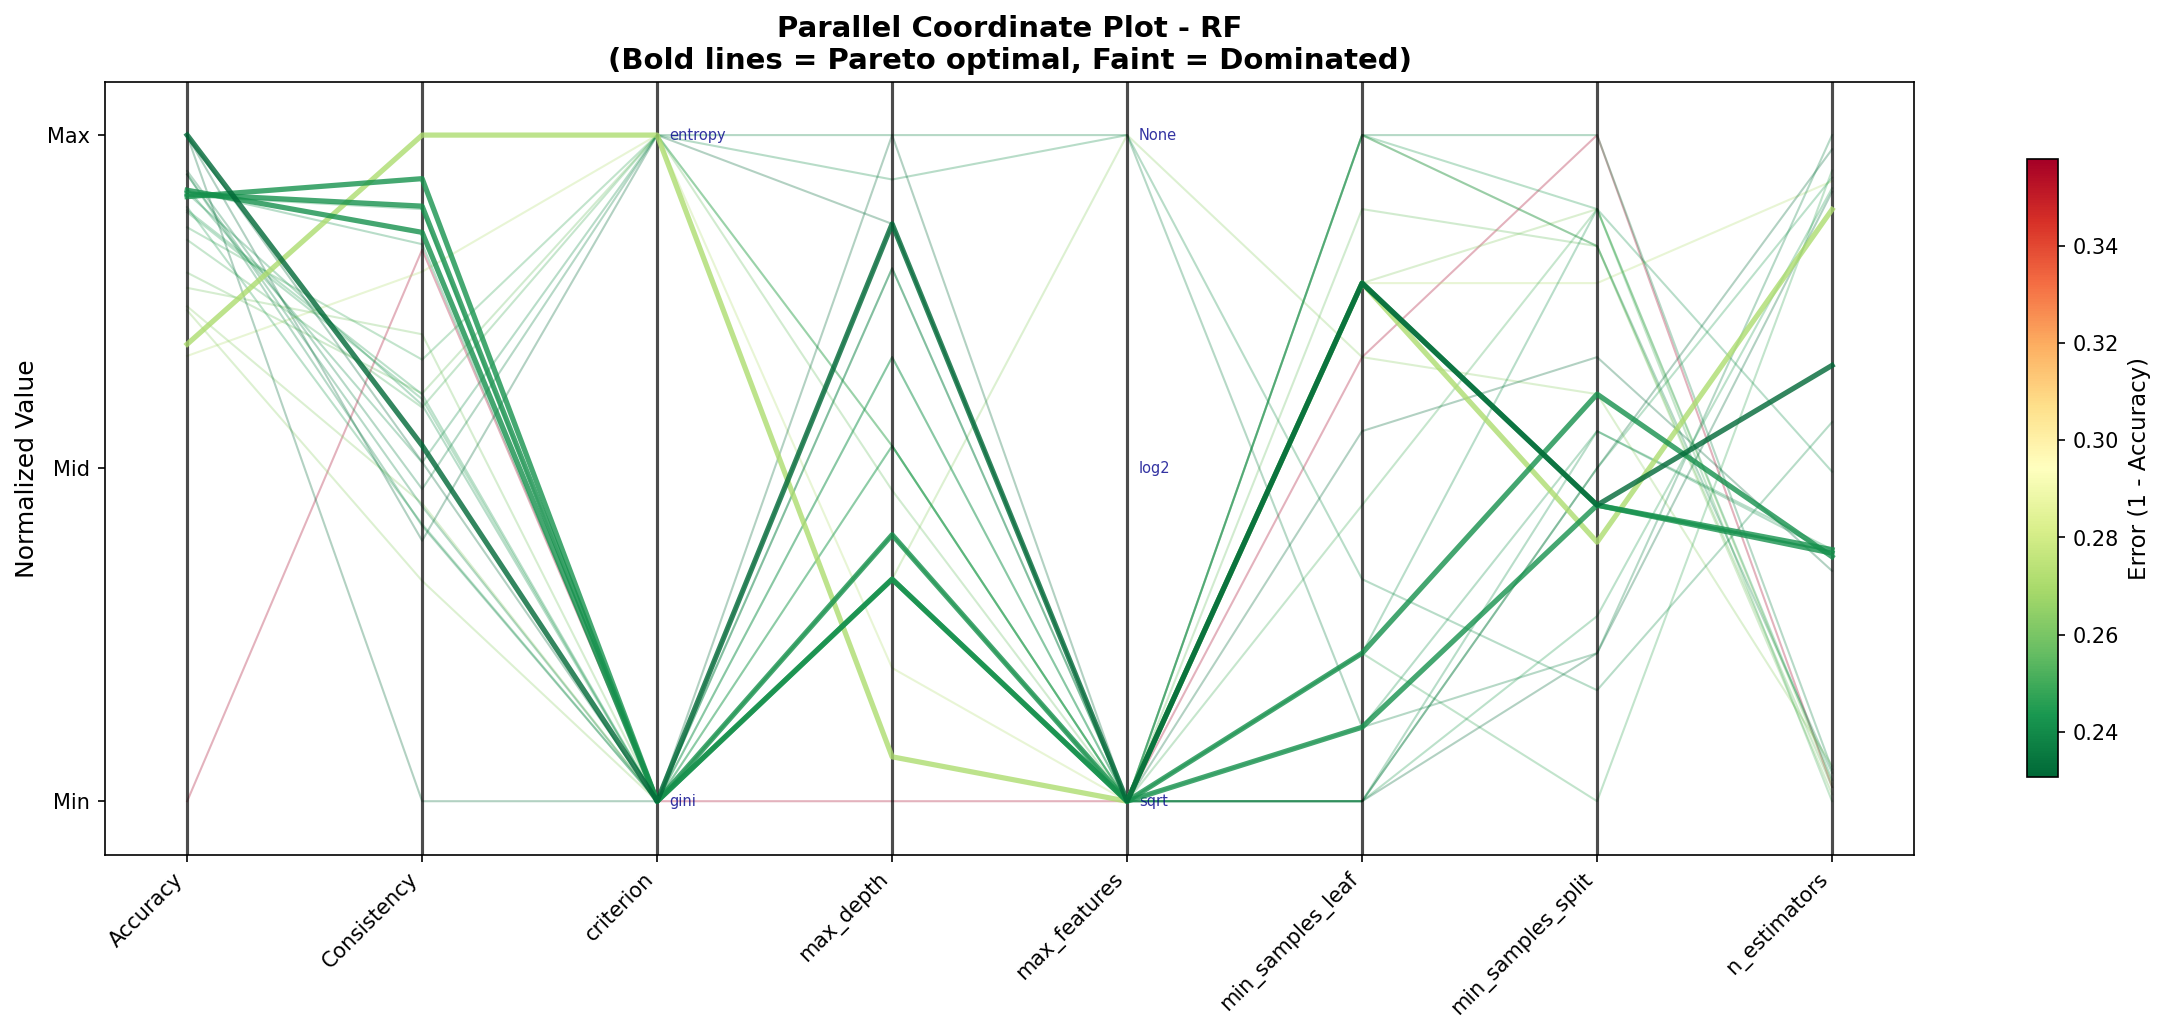

In [71]:
# Approach 2 - Random Forest Parallel Coordinates
rf_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_rf.png"
plot_parallel_coordinates(results_a2['rf'], 'rf', output_path=rf_parallel_path_a2, color_by='error')

print("\nApproach 2 - Random Forest Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_path_a2))


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_mlp.png

Approach 2 - MLP Parallel Coordinate Plot:


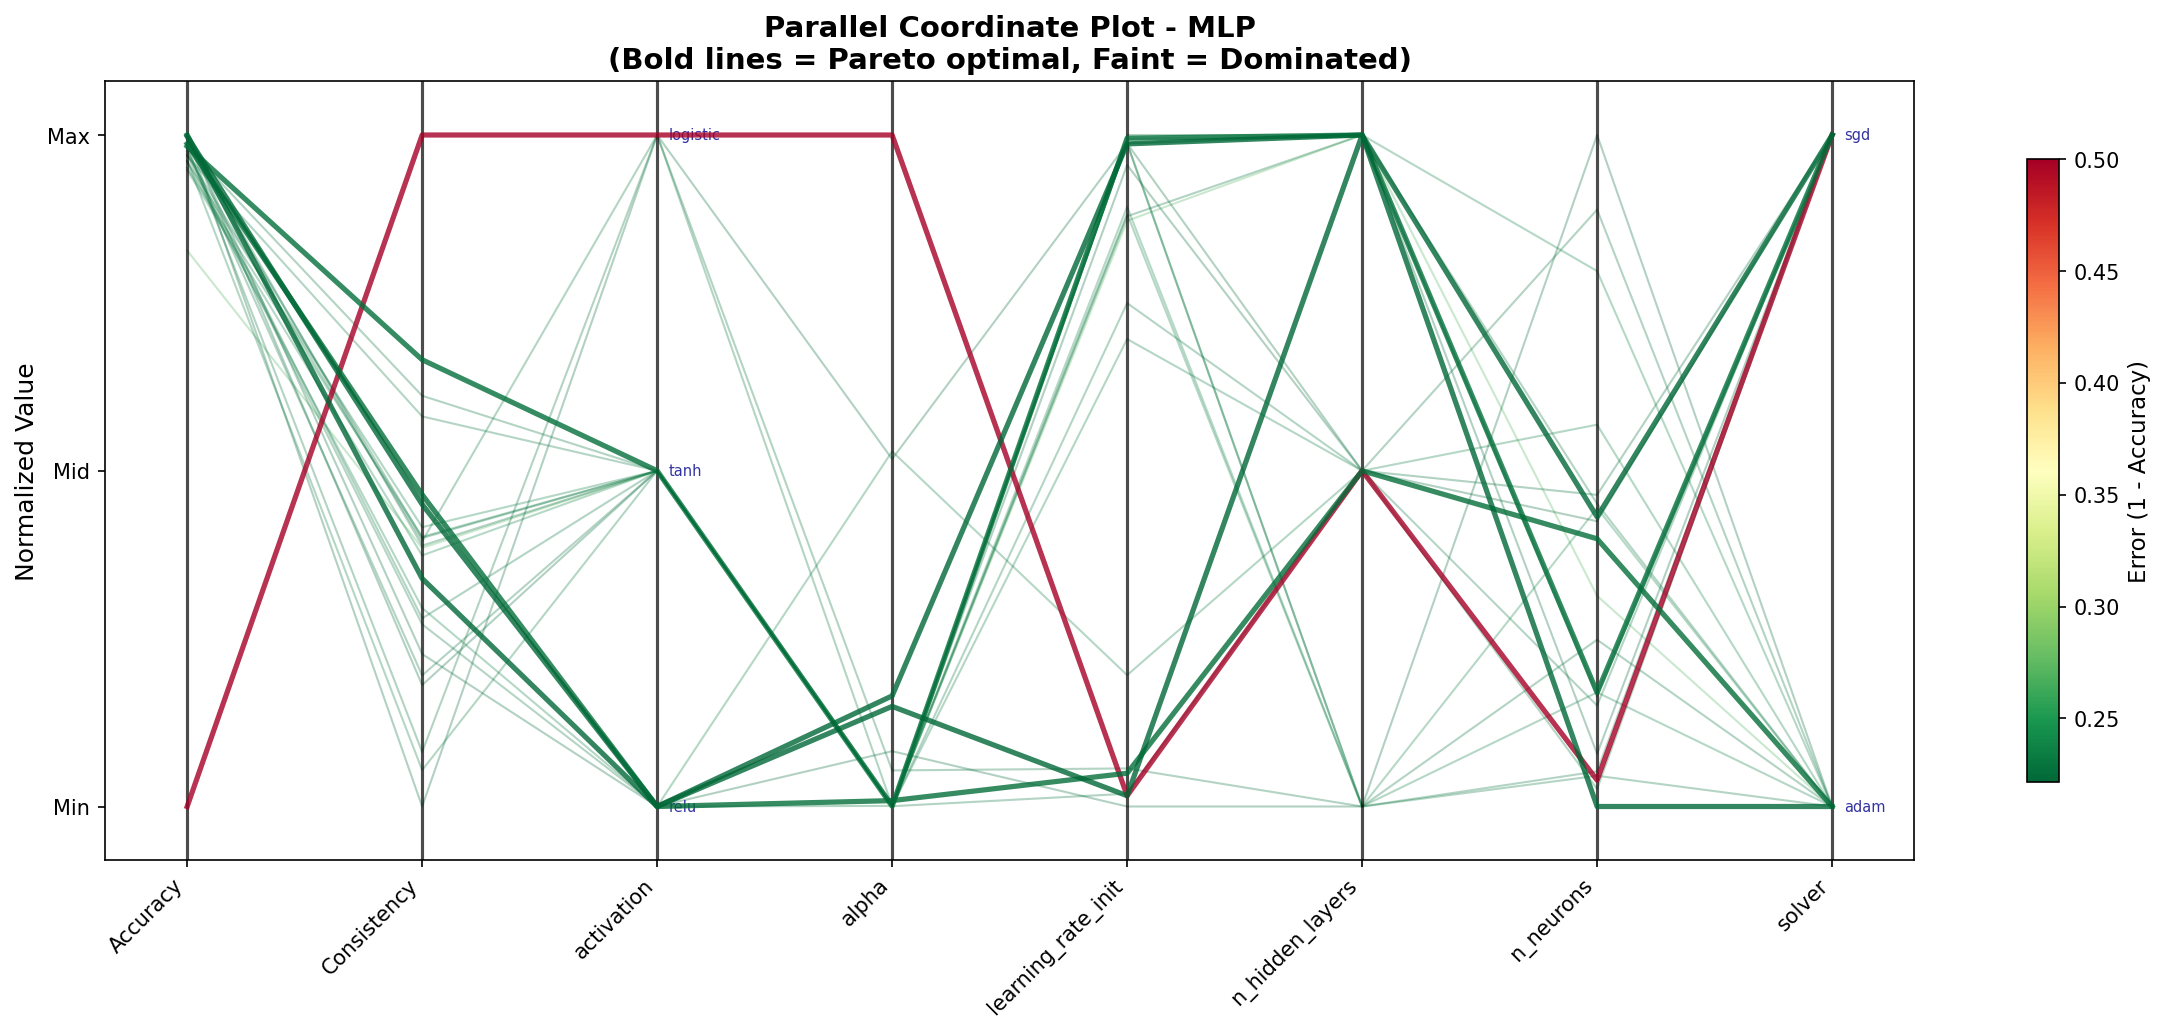

In [72]:
# Approach 2 - MLP Parallel Coordinates
mlp_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_mlp.png"
plot_parallel_coordinates(results_a2['mlp'], 'mlp', output_path=mlp_parallel_path_a2, color_by='error')

print("\nApproach 2 - MLP Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_path_a2))


MDS projection plot saved to: ../plots/mds_projection_adult_approach2_rf.png

Approach 2 - Random Forest MDS Projection:


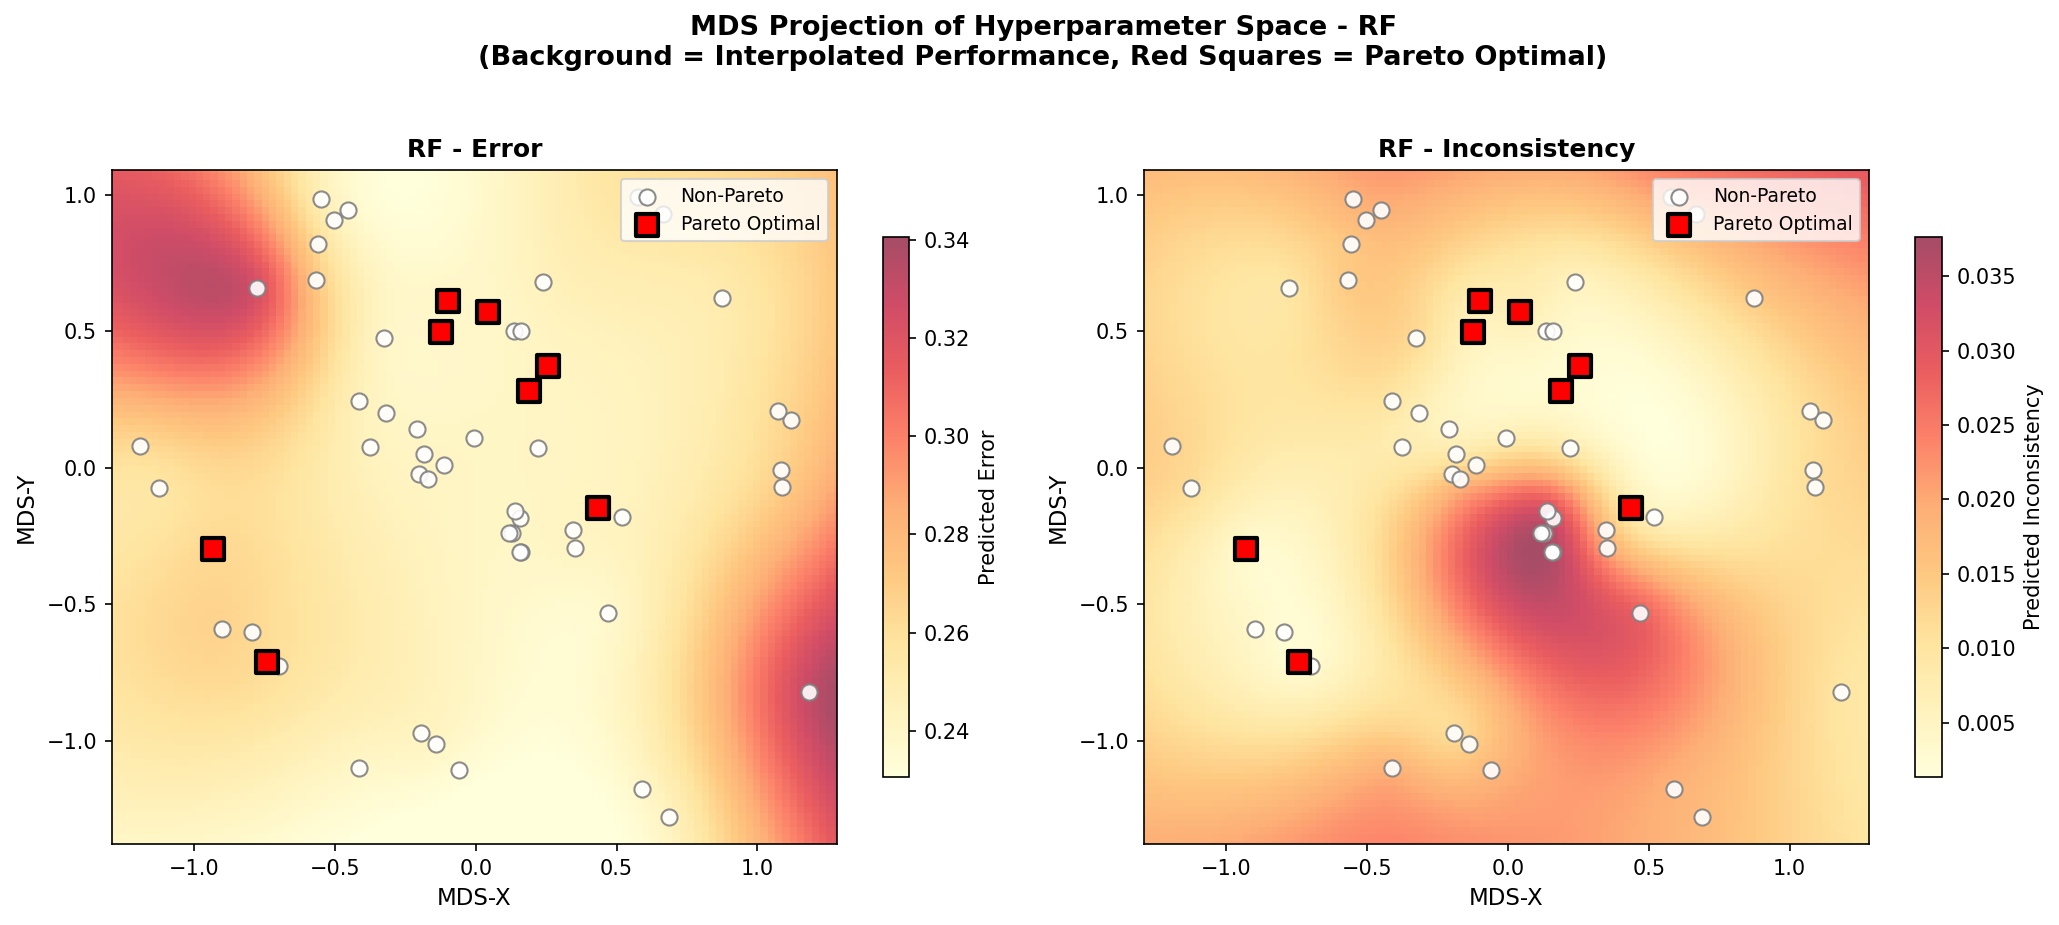

In [56]:
# Approach 2 - Random Forest MDS Projection
rf_mds_path_a2 = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME_A2}_approach2_rf.png"
plot_mds_projection(results_a2['rf'], 'rf', output_path=rf_mds_path_a2)

print("\nApproach 2 - Random Forest MDS Projection:")
display(Image(filename=rf_mds_path_a2))


## Approach 1 vs Approach 2: Comparison Summary

| Aspect | Approach 1 | Approach 2 |
|--------|-----------|-----------|
| **Sensitive features in model** | Yes (sex_Male, race_White) | No (removed) |
| **Counterfactual target** | Flip sex_Male directly | Flip relationship_Wife (proxy) |
| **Models compared** | RF, MLP | RF, MLP, SenSeI |
| **Fairness enforcement** | Post-hoc evaluation only | SenSeI: In-training enforcement |
| **Fair distance metric** | N/A | SenSeI uses LogisticRegSensitiveSubspace |

**Key questions this comparison answers:**
1. Does removing sensitive features improve fairness? (Compare RF/MLP Approach 1 vs Approach 2)
2. Does in-training fairness (SenSeI) outperform post-hoc evaluation? (Compare SenSeI vs RF/MLP)
3. Can models still discriminate via proxy features? (Approach 2 counterfactual results)


In [ ]:
# Compare best configurations from Approach 1 vs Approach 2
print("=" * 80)
print("COMPARISON: Approach 1 vs Approach 2 - Best Configurations")
print("=" * 80)

def get_best_configs(results_dict, approach_name):
    """Extract best accuracy and best fairness configs from results."""
    print(f"\n{approach_name}:")
    print("-" * 60)
    
    for model_type, smac in results_dict.items():
        configs, costs = get_pareto_front(smac)
        
        # Best accuracy
        best_acc_idx = np.argmin(costs[:, 0])
        best_acc = 1 - costs[best_acc_idx, 0]
        best_acc_cons = 1 - costs[best_acc_idx, 1]
        
        # Best consistency
        best_cons_idx = np.argmin(costs[:, 1])
        best_cons = 1 - costs[best_cons_idx, 1]
        best_cons_acc = 1 - costs[best_cons_idx, 0]
        
        print(f"\n  {model_type.upper()}:")
        print(f"    Best Accuracy:    Acc={best_acc:.4f}, Cons={best_acc_cons:.4f}")
        print(f"    Best Consistency: Acc={best_cons_acc:.4f}, Cons={best_cons:.4f}")

# # Approach 1 (with sensitive features, flip sex)
get_best_configs(results, "APPROACH 1 (With Sensitive Features, Flip Sex)")

# Approach 2 (without sensitive features, flip proxy)
get_best_configs(results_a2, "APPROACH 2 (Without Sensitive Features, Flip Proxy)")


COMPARISON: Approach 1 vs Approach 2 - Best Configurations

APPROACH 2 (Without Sensitive Features, Flip Proxy):
------------------------------------------------------------

  RF:
    Best Accuracy:    Acc=0.7693, Cons=0.9838
    Best Consistency: Acc=0.7294, Cons=1.0000

  MLP:
    Best Accuracy:    Acc=0.7786, Cons=0.9178
    Best Consistency: Acc=0.5000, Cons=1.0000

  SENSEI:
    Best Accuracy:    Acc=0.7403, Cons=0.9993
    Best Consistency: Acc=0.7403, Cons=0.9993


AttributeError: 'list' object has no attribute 'items'

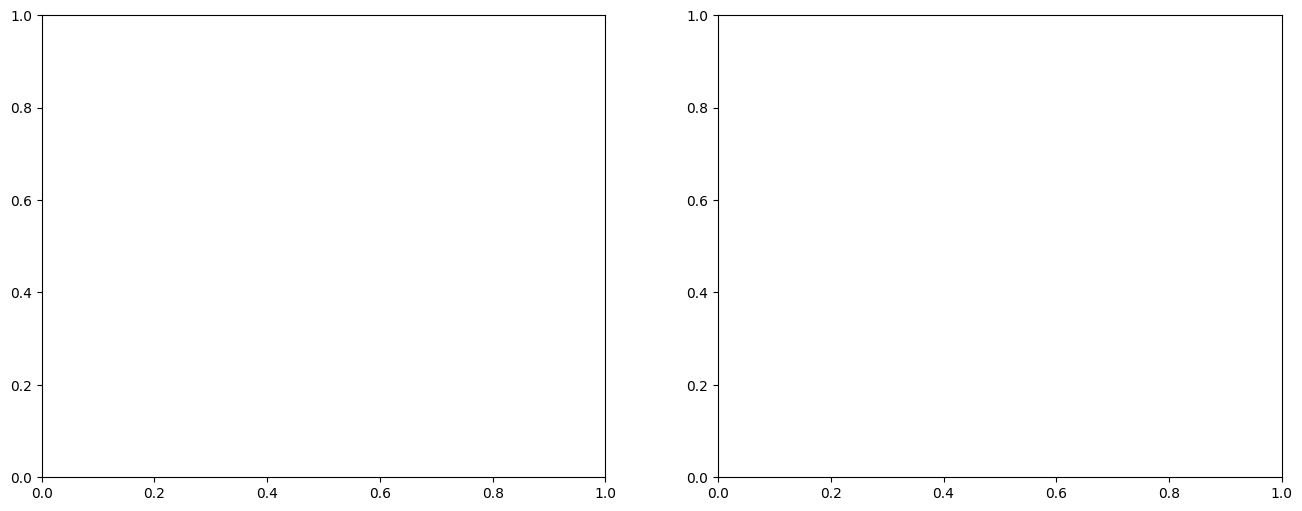

In [76]:
# Visual comparison: Approach 1 vs Approach 2 side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Common settings
colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}

# Plot Approach 1
ax = axes[0]
for model_type, smac in results.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 1: WITH Sensitive Features\n(Flip sex directly)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot Approach 2
ax = axes[1]
for model_type, smac in results_a2.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 2: WITHOUT Sensitive Features\n(Flip proxy: relationship_Wife)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Match axis limits for comparison
all_errors = []
all_incons = []
for res in [results, results_a2]:
    for smac in res.values():
        configs, costs = get_pareto_front(smac)
        all_errors.extend(costs[:, 0])
        all_incons.extend(costs[:, 1])

err_min, err_max = min(all_errors) - 0.02, max(all_errors) + 0.02
inc_min, inc_max = min(all_incons) - 0.02, max(all_incons) + 0.02

for ax in axes:
    ax.set_xlim(err_min, err_max)
    ax.set_ylim(inc_min, inc_max)

plt.suptitle('Comparison: Approach 1 vs Approach 2', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/comparison_approach1_vs_approach2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved to: {OUTPUT_DIR}/comparison_approach1_vs_approach2.png")
